In [2]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.amp import autocast
from torch.amp import GradScaler

# Transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from datasets import Dataset as HFDataset

# Metrics & Evaluation
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import joblib

# Hyperparameter Tuning
import optuna
from optuna.pruners import MedianPruner

# Paths
DATA_DIR = Path('../data')
FEATURES_DIR = Path('features')
MODELS_DIR = Path('models')
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

# Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

print("Setup Complete.")


Device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Ti
GPU Memory: 16.72 GB
Setup Complete.


In [3]:
# 6.1 Load Train/Validation Data


train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df = pd.read_csv(DATA_DIR / 'val.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')  # For final evaluation

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

X_train_text = train_df['text'].values
X_val_text = val_df['text'].values
X_test_text = test_df['text'].values

print(f"Train: {len(X_train_text)} samples")
print(f"Val: {len(X_val_text)} samples")
print(f"Test: {len(X_test_text)} samples")

# 6.2 Tokenization Strategy

print("\nTokenizing...")

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LENGTH = 256

# Tokenize all splits
train_encodings = tokenizer(
    X_train_text.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

val_encodings = tokenizer(
    X_val_text.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

test_encodings = tokenizer(
    X_test_text.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

print(f"Tokenization Complete. Max length: {MAX_LENGTH}")

# Analyze truncation
token_lengths = [len(tokenizer.encode(text, max_length=None)) for text in X_train_text[:1000]]
print(f"Token length stats (sample of 1000): min={min(token_lengths)}, max={max(token_lengths)}, mean={np.mean(token_lengths):.1f}")
print(f"Percentile 95: {np.percentile(token_lengths, 95):.0f}")


Train: 102000 samples
Val: 18000 samples
Test: 7600 samples

Tokenizing...
Tokenization Complete. Max length: 256
Token length stats (sample of 1000): min=22, max=193, mean=53.0
Percentile 95: 82


In [4]:
# 6.3 PyTorch Dataset Class

class NewsDataset(Dataset):
    """
    Custom Dataset for news classification with transformer tokenizer outputs.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

# Create datasets
train_dataset = NewsDataset(train_encodings, y_train)
val_dataset = NewsDataset(val_encodings, y_val)
test_dataset = NewsDataset(test_encodings, y_test)

# DataLoaders (batch_size=32 fits comfortably on 16GB GPU)
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Val DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")


Train DataLoader: 3188 batches
Val DataLoader: 563 batches
Test DataLoader: 238 batches


In [11]:
## **Cell 4: Training Function with Mixed Precision**

import torch
from torch.amp import autocast, GradScaler  # ← Updated import

def train_epoch(model, train_loader, optimizer, scheduler, scaler, device, epoch, num_epochs):
    """
    Train for one epoch with mixed precision training.
    """
    model.train()
    total_loss = 0.0
    
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass with autocast (FP16)
        with autocast(device_type='cuda', dtype=torch.float16):  # ← Updated
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
        
        # Backward pass
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)  # Unscale before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def evaluate(model, val_loader, device):
    """
    Evaluate on validation set. Returns loss, macro-F1, accuracy.
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast(device_type='cuda', dtype=torch.float16):  # ← Updated
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
            
            total_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, macro_f1, accuracy, all_preds, all_labels

print("Training & Evaluation functions defined.")


Training & Evaluation functions defined.


In [12]:
# 6.5 Bayesian Hyperparameter Optimization (Optuna)

def objective(trial):
    """
    Optuna objective function: Fine-tune DistilBERT and r   eturn validation Macro-F1.
    """
    
    # Hyperparameter space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.0, 0.2)
    
    # Create fresh model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=4,
        problem_type='single_label_classification'
    ).to(DEVICE)
    
    # Update dataloaders with trial batch size
    trial_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    trial_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Setup scheduler
    num_training_steps = len(trial_train_loader) * 4  # 4 epochs
    num_warmup_steps = int(num_training_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    
    # Mixed precision
    scaler = GradScaler(device='cuda')
    
    best_f1 = 0.0
    patience = 2
    patience_counter = 0
    
    # Train for 4 epochs
    for epoch in range(4):
        train_loss = train_epoch(model, trial_train_loader, optimizer, scheduler, scaler, DEVICE, epoch, 4)
        val_loss, val_f1, val_acc, _, _ = evaluate(model, trial_val_loader, DEVICE)
        
        print(f"Trial {trial.number}: Epoch {epoch+1}/4 | Val F1: {val_f1:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Prune if performance is poor
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_f1

# Run optimization
print("="*80)
print("HYPERPARAMETER OPTIMIZATION (Optuna)")
print("="*80)

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner()
)

study.optimize(objective, n_trials=10, timeout=None)

print(f"\nBest trial: {study.best_trial.number}")
print(f"Best F1: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

best_params = study.best_params
joblib.dump(best_params, RESULTS_DIR / 'step6_best_params.pkl')


HYPERPARAMETER OPTIMIZATION (Optuna)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/1594] Loss: 1.3406
Epoch [1/4] Batch [100/1594] Loss: 1.0315
Epoch [1/4] Batch [150/1594] Loss: 0.5452
Epoch [1/4] Batch [200/1594] Loss: 0.2648
Epoch [1/4] Batch [250/1594] Loss: 0.3624
Epoch [1/4] Batch [300/1594] Loss: 0.3065
Epoch [1/4] Batch [350/1594] Loss: 0.1880
Epoch [1/4] Batch [400/1594] Loss: 0.3785
Epoch [1/4] Batch [450/1594] Loss: 0.2970
Epoch [1/4] Batch [500/1594] Loss: 0.2842
Epoch [1/4] Batch [550/1594] Loss: 0.1352
Epoch [1/4] Batch [600/1594] Loss: 0.2737
Epoch [1/4] Batch [650/1594] Loss: 0.2535
Epoch [1/4] Batch [700/1594] Loss: 0.1933
Epoch [1/4] Batch [750/1594] Loss: 0.2106
Epoch [1/4] Batch [800/1594] Loss: 0.1639
Epoch [1/4] Batch [850/1594] Loss: 0.3381
Epoch [1/4] Batch [900/1594] Loss: 0.2129
Epoch [1/4] Batch [950/1594] Loss: 0.1462
Epoch [1/4] Batch [1000/1594] Loss: 0.3119
Epoch [1/4] Batch [1050/1594] Loss: 0.1564
Epoch [1/4] Batch [1100/1594] Loss: 0.1088
Epoch [1/4] Batch [1150/1594] Loss: 0.1839
Epoch [1/4] Batch [1200/1594] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/6375] Loss: 1.3773
Epoch [1/4] Batch [100/6375] Loss: 1.3499
Epoch [1/4] Batch [150/6375] Loss: 1.1476
Epoch [1/4] Batch [200/6375] Loss: 0.9652
Epoch [1/4] Batch [250/6375] Loss: 0.4536
Epoch [1/4] Batch [300/6375] Loss: 0.2849
Epoch [1/4] Batch [350/6375] Loss: 0.2168
Epoch [1/4] Batch [400/6375] Loss: 0.2150
Epoch [1/4] Batch [450/6375] Loss: 0.3443
Epoch [1/4] Batch [500/6375] Loss: 0.3259
Epoch [1/4] Batch [550/6375] Loss: 0.2219
Epoch [1/4] Batch [600/6375] Loss: 0.7114
Epoch [1/4] Batch [650/6375] Loss: 0.2524
Epoch [1/4] Batch [700/6375] Loss: 0.2224
Epoch [1/4] Batch [750/6375] Loss: 0.0491
Epoch [1/4] Batch [800/6375] Loss: 0.4119
Epoch [1/4] Batch [850/6375] Loss: 0.0793
Epoch [1/4] Batch [900/6375] Loss: 0.3252
Epoch [1/4] Batch [950/6375] Loss: 0.4528
Epoch [1/4] Batch [1000/6375] Loss: 0.2461
Epoch [1/4] Batch [1050/6375] Loss: 0.1552
Epoch [1/4] Batch [1100/6375] Loss: 0.2483
Epoch [1/4] Batch [1150/6375] Loss: 0.0335
Epoch [1/4] Batch [1200/6375] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/6375] Loss: 1.3951
Epoch [1/4] Batch [100/6375] Loss: 1.3536
Epoch [1/4] Batch [150/6375] Loss: 1.2499
Epoch [1/4] Batch [200/6375] Loss: 0.9934
Epoch [1/4] Batch [250/6375] Loss: 0.7752
Epoch [1/4] Batch [300/6375] Loss: 0.5290
Epoch [1/4] Batch [350/6375] Loss: 0.3910
Epoch [1/4] Batch [400/6375] Loss: 0.1691
Epoch [1/4] Batch [450/6375] Loss: 0.4844
Epoch [1/4] Batch [500/6375] Loss: 0.3538
Epoch [1/4] Batch [550/6375] Loss: 0.1965
Epoch [1/4] Batch [600/6375] Loss: 0.3178
Epoch [1/4] Batch [650/6375] Loss: 0.1672
Epoch [1/4] Batch [700/6375] Loss: 0.6186
Epoch [1/4] Batch [750/6375] Loss: 0.5924
Epoch [1/4] Batch [800/6375] Loss: 0.6317
Epoch [1/4] Batch [850/6375] Loss: 0.6145
Epoch [1/4] Batch [900/6375] Loss: 0.2645
Epoch [1/4] Batch [950/6375] Loss: 0.5941
Epoch [1/4] Batch [1000/6375] Loss: 0.4362
Epoch [1/4] Batch [1050/6375] Loss: 0.3938
Epoch [1/4] Batch [1100/6375] Loss: 0.4577
Epoch [1/4] Batch [1150/6375] Loss: 0.4026
Epoch [1/4] Batch [1200/6375] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/1594] Loss: 1.3719
Epoch [1/4] Batch [100/1594] Loss: 1.2973
Epoch [1/4] Batch [150/1594] Loss: 1.0539
Epoch [1/4] Batch [200/1594] Loss: 0.6777
Epoch [1/4] Batch [250/1594] Loss: 0.4197
Epoch [1/4] Batch [300/1594] Loss: 0.3673
Epoch [1/4] Batch [350/1594] Loss: 0.3154
Epoch [1/4] Batch [400/1594] Loss: 0.3223
Epoch [1/4] Batch [450/1594] Loss: 0.3026
Epoch [1/4] Batch [500/1594] Loss: 0.2160
Epoch [1/4] Batch [550/1594] Loss: 0.4060
Epoch [1/4] Batch [600/1594] Loss: 0.4596
Epoch [1/4] Batch [650/1594] Loss: 0.2755
Epoch [1/4] Batch [700/1594] Loss: 0.1465
Epoch [1/4] Batch [750/1594] Loss: 0.2771
Epoch [1/4] Batch [800/1594] Loss: 0.2244
Epoch [1/4] Batch [850/1594] Loss: 0.2644
Epoch [1/4] Batch [900/1594] Loss: 0.2560
Epoch [1/4] Batch [950/1594] Loss: 0.3183
Epoch [1/4] Batch [1000/1594] Loss: 0.1774
Epoch [1/4] Batch [1050/1594] Loss: 0.1765
Epoch [1/4] Batch [1100/1594] Loss: 0.2454
Epoch [1/4] Batch [1150/1594] Loss: 0.2933
Epoch [1/4] Batch [1200/1594] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/3188] Loss: 1.4019
Epoch [1/4] Batch [100/3188] Loss: 1.3599
Epoch [1/4] Batch [150/3188] Loss: 1.2275
Epoch [1/4] Batch [200/3188] Loss: 0.8179
Epoch [1/4] Batch [250/3188] Loss: 0.6219
Epoch [1/4] Batch [300/3188] Loss: 0.3929
Epoch [1/4] Batch [350/3188] Loss: 0.1903
Epoch [1/4] Batch [400/3188] Loss: 0.3658
Epoch [1/4] Batch [450/3188] Loss: 0.2194
Epoch [1/4] Batch [500/3188] Loss: 0.4303
Epoch [1/4] Batch [550/3188] Loss: 0.4212
Epoch [1/4] Batch [600/3188] Loss: 0.3557
Epoch [1/4] Batch [650/3188] Loss: 0.3756
Epoch [1/4] Batch [700/3188] Loss: 0.1607
Epoch [1/4] Batch [750/3188] Loss: 0.2265
Epoch [1/4] Batch [800/3188] Loss: 0.2704
Epoch [1/4] Batch [850/3188] Loss: 0.4575
Epoch [1/4] Batch [900/3188] Loss: 0.1138
Epoch [1/4] Batch [950/3188] Loss: 0.3309
Epoch [1/4] Batch [1000/3188] Loss: 0.0648
Epoch [1/4] Batch [1050/3188] Loss: 0.3042
Epoch [1/4] Batch [1100/3188] Loss: 0.2275
Epoch [1/4] Batch [1150/3188] Loss: 0.5009
Epoch [1/4] Batch [1200/3188] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/6375] Loss: 1.3957
Epoch [1/4] Batch [100/6375] Loss: 1.3765
Epoch [1/4] Batch [150/6375] Loss: 1.3644
Epoch [1/4] Batch [200/6375] Loss: 1.3439
Epoch [1/4] Batch [250/6375] Loss: 1.3536
Epoch [1/4] Batch [300/6375] Loss: 1.2218
Epoch [1/4] Batch [350/6375] Loss: 1.0472
Epoch [1/4] Batch [400/6375] Loss: 0.9203
Epoch [1/4] Batch [450/6375] Loss: 0.9045
Epoch [1/4] Batch [500/6375] Loss: 0.7847
Epoch [1/4] Batch [550/6375] Loss: 0.6270
Epoch [1/4] Batch [600/6375] Loss: 0.4874
Epoch [1/4] Batch [650/6375] Loss: 0.5151
Epoch [1/4] Batch [700/6375] Loss: 0.2743
Epoch [1/4] Batch [750/6375] Loss: 0.5950
Epoch [1/4] Batch [800/6375] Loss: 0.3559
Epoch [1/4] Batch [850/6375] Loss: 0.2308
Epoch [1/4] Batch [900/6375] Loss: 0.2203
Epoch [1/4] Batch [950/6375] Loss: 0.4587
Epoch [1/4] Batch [1000/6375] Loss: 0.3610
Epoch [1/4] Batch [1050/6375] Loss: 0.3076
Epoch [1/4] Batch [1100/6375] Loss: 0.4214
Epoch [1/4] Batch [1150/6375] Loss: 0.0925
Epoch [1/4] Batch [1200/6375] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/1594] Loss: 1.3343
Epoch [1/4] Batch [100/1594] Loss: 0.6775
Epoch [1/4] Batch [150/1594] Loss: 0.3801
Epoch [1/4] Batch [200/1594] Loss: 0.3015
Epoch [1/4] Batch [250/1594] Loss: 0.2176
Epoch [1/4] Batch [300/1594] Loss: 0.2284
Epoch [1/4] Batch [350/1594] Loss: 0.1886
Epoch [1/4] Batch [400/1594] Loss: 0.2581
Epoch [1/4] Batch [450/1594] Loss: 0.3781
Epoch [1/4] Batch [500/1594] Loss: 0.1735
Epoch [1/4] Batch [550/1594] Loss: 0.2230
Epoch [1/4] Batch [600/1594] Loss: 0.2202
Epoch [1/4] Batch [650/1594] Loss: 0.1214
Epoch [1/4] Batch [700/1594] Loss: 0.1492
Epoch [1/4] Batch [750/1594] Loss: 0.1643
Epoch [1/4] Batch [800/1594] Loss: 0.1083
Epoch [1/4] Batch [850/1594] Loss: 0.3222
Epoch [1/4] Batch [900/1594] Loss: 0.3280
Epoch [1/4] Batch [950/1594] Loss: 0.2615
Epoch [1/4] Batch [1000/1594] Loss: 0.1953
Epoch [1/4] Batch [1050/1594] Loss: 0.2652
Epoch [1/4] Batch [1100/1594] Loss: 0.1307
Epoch [1/4] Batch [1150/1594] Loss: 0.1172
Epoch [1/4] Batch [1200/1594] L

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 4f529bff-af5e-4834-ab93-cf3a67d00beb)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/6375] Loss: 1.4072
Epoch [1/4] Batch [100/6375] Loss: 1.3809
Epoch [1/4] Batch [150/6375] Loss: 1.3224
Epoch [1/4] Batch [200/6375] Loss: 1.3012
Epoch [1/4] Batch [250/6375] Loss: 1.2321
Epoch [1/4] Batch [300/6375] Loss: 1.1375
Epoch [1/4] Batch [350/6375] Loss: 0.7747
Epoch [1/4] Batch [400/6375] Loss: 0.7930
Epoch [1/4] Batch [450/6375] Loss: 0.5058
Epoch [1/4] Batch [500/6375] Loss: 0.3500
Epoch [1/4] Batch [550/6375] Loss: 0.6804
Epoch [1/4] Batch [600/6375] Loss: 0.3138
Epoch [1/4] Batch [650/6375] Loss: 0.3602
Epoch [1/4] Batch [700/6375] Loss: 0.8109
Epoch [1/4] Batch [750/6375] Loss: 0.2681
Epoch [1/4] Batch [800/6375] Loss: 0.2071
Epoch [1/4] Batch [850/6375] Loss: 0.2255
Epoch [1/4] Batch [900/6375] Loss: 0.3588
Epoch [1/4] Batch [950/6375] Loss: 0.4948
Epoch [1/4] Batch [1000/6375] Loss: 0.4071
Epoch [1/4] Batch [1050/6375] Loss: 0.2521
Epoch [1/4] Batch [1100/6375] Loss: 0.2570
Epoch [1/4] Batch [1150/6375] Loss: 0.2005
Epoch [1/4] Batch [1200/6375] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/3188] Loss: 1.3831
Epoch [1/4] Batch [100/3188] Loss: 1.2611
Epoch [1/4] Batch [150/3188] Loss: 0.8910
Epoch [1/4] Batch [200/3188] Loss: 0.7109
Epoch [1/4] Batch [250/3188] Loss: 0.3691
Epoch [1/4] Batch [300/3188] Loss: 0.3024
Epoch [1/4] Batch [350/3188] Loss: 0.3970
Epoch [1/4] Batch [400/3188] Loss: 0.3972
Epoch [1/4] Batch [450/3188] Loss: 0.5582
Epoch [1/4] Batch [500/3188] Loss: 0.3379
Epoch [1/4] Batch [550/3188] Loss: 0.2694
Epoch [1/4] Batch [600/3188] Loss: 0.3704
Epoch [1/4] Batch [650/3188] Loss: 0.3146
Epoch [1/4] Batch [700/3188] Loss: 0.1192
Epoch [1/4] Batch [750/3188] Loss: 0.2633
Epoch [1/4] Batch [800/3188] Loss: 0.0613
Epoch [1/4] Batch [850/3188] Loss: 0.2091
Epoch [1/4] Batch [900/3188] Loss: 0.1936
Epoch [1/4] Batch [950/3188] Loss: 0.2863
Epoch [1/4] Batch [1000/3188] Loss: 0.1805
Epoch [1/4] Batch [1050/3188] Loss: 0.1216
Epoch [1/4] Batch [1100/3188] Loss: 0.1627
Epoch [1/4] Batch [1150/3188] Loss: 0.3233
Epoch [1/4] Batch [1200/3188] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/6375] Loss: 1.3717
Epoch [1/4] Batch [100/6375] Loss: 1.3756
Epoch [1/4] Batch [150/6375] Loss: 1.3537
Epoch [1/4] Batch [200/6375] Loss: 1.3336
Epoch [1/4] Batch [250/6375] Loss: 1.2231
Epoch [1/4] Batch [300/6375] Loss: 1.1441
Epoch [1/4] Batch [350/6375] Loss: 0.9259
Epoch [1/4] Batch [400/6375] Loss: 0.6979
Epoch [1/4] Batch [450/6375] Loss: 0.3857
Epoch [1/4] Batch [500/6375] Loss: 0.4256
Epoch [1/4] Batch [550/6375] Loss: 0.3369
Epoch [1/4] Batch [600/6375] Loss: 0.4666
Epoch [1/4] Batch [650/6375] Loss: 0.6317
Epoch [1/4] Batch [700/6375] Loss: 0.2567
Epoch [1/4] Batch [750/6375] Loss: 0.4283
Epoch [1/4] Batch [800/6375] Loss: 0.3467
Epoch [1/4] Batch [850/6375] Loss: 0.4104
Epoch [1/4] Batch [900/6375] Loss: 0.3019
Epoch [1/4] Batch [950/6375] Loss: 0.9248
Epoch [1/4] Batch [1000/6375] Loss: 0.4136
Epoch [1/4] Batch [1050/6375] Loss: 0.8139
Epoch [1/4] Batch [1100/6375] Loss: 0.2301
Epoch [1/4] Batch [1150/6375] Loss: 0.4543
Epoch [1/4] Batch [1200/6375] L

['results/step6_best_params.pkl']

In [13]:
# 6.6 Train Final Model with Best Hyperparameters


# Load best hyperparameters
best_params = joblib.load(RESULTS_DIR / 'step6_best_params.pkl')

learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
weight_decay = best_params['weight_decay']
warmup_ratio = best_params['warmup_ratio']

print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Weight Decay: {weight_decay}")
print(f"Warmup Ratio: {warmup_ratio}")

# Create model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    problem_type='single_label_classification'
).to(DEVICE)

# Create dataloaders with best batch size
final_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
final_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_training_steps = len(final_train_loader) * 4
num_warmup_steps = int(num_training_steps * warmup_ratio)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

scaler = GradScaler(device='cuda')

# Training loop with checkpointing
best_val_f1 = 0.0
training_history = defaultdict(list)

for epoch in range(4):
    train_loss = train_epoch(model, final_train_loader, optimizer, scheduler, scaler, DEVICE, epoch, 4)
    val_loss, val_f1, val_acc, _, _ = evaluate(model, final_val_loader, DEVICE)
    
    training_history['epoch'].append(epoch + 1)
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['val_f1'].append(val_f1)
    training_history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/4 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save checkpoint if best
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        model.save_pretrained(MODELS_DIR / 'step6_distilbert_best')
        tokenizer.save_pretrained(MODELS_DIR / 'step6_distilbert_best')
        print(f"Checkpoint saved (F1: {val_f1:.4f})")

print("\nTraining Complete!")
print(f"Best Validation F1: {best_val_f1:.4f}")

# Save training history
history_df = pd.DataFrame(training_history)
history_df.to_csv(RESULTS_DIR / 'step6_training_history.csv', index=False)


Learning Rate: 2.8219443464878743e-05
Batch Size: 64
Weight Decay: 0.021537846530908268
Warmup Ratio: 0.04481839946966742


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4] Batch [50/1594] Loss: 1.3004
Epoch [1/4] Batch [100/1594] Loss: 0.6091
Epoch [1/4] Batch [150/1594] Loss: 0.3182
Epoch [1/4] Batch [200/1594] Loss: 0.3761
Epoch [1/4] Batch [250/1594] Loss: 0.3023
Epoch [1/4] Batch [300/1594] Loss: 0.5146
Epoch [1/4] Batch [350/1594] Loss: 0.2114
Epoch [1/4] Batch [400/1594] Loss: 0.2020
Epoch [1/4] Batch [450/1594] Loss: 0.1664
Epoch [1/4] Batch [500/1594] Loss: 0.1133
Epoch [1/4] Batch [550/1594] Loss: 0.2074
Epoch [1/4] Batch [600/1594] Loss: 0.1607
Epoch [1/4] Batch [650/1594] Loss: 0.2288
Epoch [1/4] Batch [700/1594] Loss: 0.2200
Epoch [1/4] Batch [750/1594] Loss: 0.1388
Epoch [1/4] Batch [800/1594] Loss: 0.3588
Epoch [1/4] Batch [850/1594] Loss: 0.1437
Epoch [1/4] Batch [900/1594] Loss: 0.1700
Epoch [1/4] Batch [950/1594] Loss: 0.1307
Epoch [1/4] Batch [1000/1594] Loss: 0.2112
Epoch [1/4] Batch [1050/1594] Loss: 0.1784
Epoch [1/4] Batch [1100/1594] Loss: 0.1487
Epoch [1/4] Batch [1150/1594] Loss: 0.0426
Epoch [1/4] Batch [1200/1594] L

In [14]:
# 6.7 Final Test Set Evaluation


# Load best model
best_model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / 'step6_distilbert_best'
).to(DEVICE)

# Evaluate on test set
test_loss, test_f1, test_acc, test_preds, test_labels = evaluate(best_model, test_loader, DEVICE)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Save results
results = {
    'test_loss': test_loss,
    'test_macro_f1': test_f1,
    'test_accuracy': test_acc,
    'test_predictions': test_preds,
    'test_labels': test_labels,
    'confusion_matrix': conf_matrix
}

joblib.dump(results, RESULTS_DIR / 'step6_test_results.pkl')
print("\nResults saved.")


Test Loss: 0.1818
Test Macro-F1: 0.9423
Test Accuracy: 0.9422

Classification Report:
              precision    recall  f1-score   support

       World     0.9606    0.9489    0.9547      1900
      Sports     0.9853    0.9879    0.9866      1900
    Business     0.9064    0.9179    0.9121      1900
    Sci/Tech     0.9171    0.9142    0.9157      1900

    accuracy                         0.9422      7600
   macro avg     0.9424    0.9422    0.9423      7600
weighted avg     0.9424    0.9422    0.9423      7600


Confusion Matrix:
[[1803   14   47   36]
 [  10 1877    7    6]
 [  36    5 1744  115]
 [  28    9  126 1737]]

Results saved.


In [15]:
# 6.8 Ablation 1: Frozen Embeddings vs. Full Fine-Tuning


ablation_results = {}

# Scenario 1: Freeze all DistilBERT layers, train only classification head
print("\n1. Frozen DistilBERT (only train classification head)...")
model_frozen = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4).to(DEVICE)

for param in model_frozen.distilbert.parameters():
    param.requires_grad = False

optimizer_frozen = AdamW(model_frozen.parameters(), lr=2e-4, weight_decay=0.01)
scaler_frozen = GradScaler(device='cuda')

best_frozen_f1 = 0.0
for epoch in range(2):  # Fewer epochs for frozen
    train_loss = train_epoch(model_frozen, final_train_loader, optimizer_frozen, scheduler, scaler_frozen, DEVICE, epoch, 2)
    val_loss, val_f1, val_acc, _, _ = evaluate(model_frozen, final_val_loader, DEVICE)
    print(f"Epoch {epoch+1}: Val F1: {val_f1:.4f}")
    best_frozen_f1 = max(best_frozen_f1, val_f1)

ablation_results['frozen_f1'] = best_frozen_f1
print(f"Frozen Model Best F1: {best_frozen_f1:.4f}")

# Scenario 2: Full fine-tuning (already done above)
ablation_results['full_tuning_f1'] = best_val_f1
print(f"Full Fine-Tuning Best F1: {best_val_f1:.4f}")

# Comparison
gain = best_val_f1 - best_frozen_f1
print(f"\nGain from Full Fine-Tuning: {gain:.4f} ({gain*100:.2f}%)")

joblib.dump(ablation_results, RESULTS_DIR / 'step6_ablation_frozen_vs_tuned.pkl')



1. Frozen DistilBERT (only train classification head)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2] Batch [50/1594] Loss: 0.4481
Epoch [1/2] Batch [100/1594] Loss: 0.4780
Epoch [1/2] Batch [150/1594] Loss: 0.2372
Epoch [1/2] Batch [200/1594] Loss: 0.4479
Epoch [1/2] Batch [250/1594] Loss: 0.3457
Epoch [1/2] Batch [300/1594] Loss: 0.3995
Epoch [1/2] Batch [350/1594] Loss: 0.3741
Epoch [1/2] Batch [400/1594] Loss: 0.3730
Epoch [1/2] Batch [450/1594] Loss: 0.4120
Epoch [1/2] Batch [500/1594] Loss: 0.2431
Epoch [1/2] Batch [550/1594] Loss: 0.3817
Epoch [1/2] Batch [600/1594] Loss: 0.3543
Epoch [1/2] Batch [650/1594] Loss: 0.2669
Epoch [1/2] Batch [700/1594] Loss: 0.3007
Epoch [1/2] Batch [750/1594] Loss: 0.1818
Epoch [1/2] Batch [800/1594] Loss: 0.2533
Epoch [1/2] Batch [850/1594] Loss: 0.2527
Epoch [1/2] Batch [900/1594] Loss: 0.2087
Epoch [1/2] Batch [950/1594] Loss: 0.2897
Epoch [1/2] Batch [1000/1594] Loss: 0.2632
Epoch [1/2] Batch [1050/1594] Loss: 0.3365
Epoch [1/2] Batch [1100/1594] Loss: 0.3479
Epoch [1/2] Batch [1150/1594] Loss: 0.1305
Epoch [1/2] Batch [1200/1594] L

['results/step6_ablation_frozen_vs_tuned.pkl']

In [16]:
# 6.9 Ablation 2: Max Sequence Length Impact


max_lengths = [128, 256, 512]
length_results = {}

for max_len in max_lengths:
    print(f"\nTesting MAX_LENGTH = {max_len}...")
    
    # Re-tokenize
    temp_train_enc = tokenizer(
        X_train_text.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    
    temp_val_enc = tokenizer(
        X_val_text.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    
    temp_train_dataset = NewsDataset(temp_train_enc, y_train)
    temp_val_dataset = NewsDataset(temp_val_enc, y_val)
    
    temp_train_loader = DataLoader(temp_train_dataset, batch_size=32, shuffle=True)
    temp_val_loader = DataLoader(temp_val_dataset, batch_size=32, shuffle=False)
    
    # Quick 2-epoch training
    model_temp = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4).to(DEVICE)
    optimizer_temp = AdamW(model_temp.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler_temp = GradScaler(device='cuda')
    
    best_f1_temp = 0.0
    for epoch in range(2):
        train_loss = train_epoch(model_temp, temp_train_loader, optimizer_temp, scheduler, scaler_temp, DEVICE, epoch, 2)
        val_loss, val_f1, val_acc, _, _ = evaluate(model_temp, temp_val_loader, DEVICE)
        best_f1_temp = max(best_f1_temp, val_f1)
    
    length_results[max_len] = best_f1_temp
    print(f"Max Length {max_len}: Best Val F1 = {best_f1_temp:.4f}")

joblib.dump(length_results, RESULTS_DIR / 'step6_ablation_sequence_length.pkl')
print(f"\nSequence Length Results: {length_results}")



Testing MAX_LENGTH = 128...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2] Batch [50/3188] Loss: 0.3548
Epoch [1/2] Batch [100/3188] Loss: 0.4136
Epoch [1/2] Batch [150/3188] Loss: 0.1985
Epoch [1/2] Batch [200/3188] Loss: 0.4134
Epoch [1/2] Batch [250/3188] Loss: 0.3583
Epoch [1/2] Batch [300/3188] Loss: 0.4257
Epoch [1/2] Batch [350/3188] Loss: 0.2784
Epoch [1/2] Batch [400/3188] Loss: 0.3622
Epoch [1/2] Batch [450/3188] Loss: 0.3804
Epoch [1/2] Batch [500/3188] Loss: 0.2374
Epoch [1/2] Batch [550/3188] Loss: 0.6169
Epoch [1/2] Batch [600/3188] Loss: 0.4351
Epoch [1/2] Batch [650/3188] Loss: 0.1685
Epoch [1/2] Batch [700/3188] Loss: 0.1212
Epoch [1/2] Batch [750/3188] Loss: 0.1415
Epoch [1/2] Batch [800/3188] Loss: 0.3537
Epoch [1/2] Batch [850/3188] Loss: 0.1776
Epoch [1/2] Batch [900/3188] Loss: 0.2954
Epoch [1/2] Batch [950/3188] Loss: 0.4112
Epoch [1/2] Batch [1000/3188] Loss: 0.0660
Epoch [1/2] Batch [1050/3188] Loss: 0.5133
Epoch [1/2] Batch [1100/3188] Loss: 0.2524
Epoch [1/2] Batch [1150/3188] Loss: 0.2792
Epoch [1/2] Batch [1200/3188] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2] Batch [50/3188] Loss: 0.5544
Epoch [1/2] Batch [100/3188] Loss: 0.2415
Epoch [1/2] Batch [150/3188] Loss: 0.3941
Epoch [1/2] Batch [200/3188] Loss: 0.4168
Epoch [1/2] Batch [250/3188] Loss: 0.2073
Epoch [1/2] Batch [300/3188] Loss: 0.6041
Epoch [1/2] Batch [350/3188] Loss: 0.3664
Epoch [1/2] Batch [400/3188] Loss: 0.1065
Epoch [1/2] Batch [450/3188] Loss: 0.0584
Epoch [1/2] Batch [500/3188] Loss: 0.0737
Epoch [1/2] Batch [550/3188] Loss: 0.6780
Epoch [1/2] Batch [600/3188] Loss: 0.2507
Epoch [1/2] Batch [650/3188] Loss: 0.3120
Epoch [1/2] Batch [700/3188] Loss: 0.5305
Epoch [1/2] Batch [750/3188] Loss: 0.0719
Epoch [1/2] Batch [800/3188] Loss: 0.3655
Epoch [1/2] Batch [850/3188] Loss: 0.1167
Epoch [1/2] Batch [900/3188] Loss: 0.2603
Epoch [1/2] Batch [950/3188] Loss: 0.1351
Epoch [1/2] Batch [1000/3188] Loss: 0.1779
Epoch [1/2] Batch [1050/3188] Loss: 0.2989
Epoch [1/2] Batch [1100/3188] Loss: 0.1538
Epoch [1/2] Batch [1150/3188] Loss: 0.1468
Epoch [1/2] Batch [1200/3188] L

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2] Batch [50/3188] Loss: 0.5616
Epoch [1/2] Batch [100/3188] Loss: 0.2703
Epoch [1/2] Batch [150/3188] Loss: 0.7215
Epoch [1/2] Batch [200/3188] Loss: 0.3663
Epoch [1/2] Batch [250/3188] Loss: 0.4736
Epoch [1/2] Batch [300/3188] Loss: 0.0952
Epoch [1/2] Batch [350/3188] Loss: 0.1000
Epoch [1/2] Batch [400/3188] Loss: 0.2248
Epoch [1/2] Batch [450/3188] Loss: 0.1906
Epoch [1/2] Batch [500/3188] Loss: 0.0929
Epoch [1/2] Batch [550/3188] Loss: 0.1641
Epoch [1/2] Batch [600/3188] Loss: 0.1670
Epoch [1/2] Batch [650/3188] Loss: 0.3587
Epoch [1/2] Batch [700/3188] Loss: 0.1807
Epoch [1/2] Batch [750/3188] Loss: 0.2298
Epoch [1/2] Batch [800/3188] Loss: 0.2432
Epoch [1/2] Batch [850/3188] Loss: 0.0831
Epoch [1/2] Batch [900/3188] Loss: 0.2770
Epoch [1/2] Batch [950/3188] Loss: 0.1582
Epoch [1/2] Batch [1000/3188] Loss: 0.1818
Epoch [1/2] Batch [1050/3188] Loss: 0.2704
Epoch [1/2] Batch [1100/3188] Loss: 0.2807
Epoch [1/2] Batch [1150/3188] Loss: 0.2244
Epoch [1/2] Batch [1200/3188] L

In [17]:
# 6.10 Comparison: DistilBERT vs. Classical Models


# Load classical models' test results (from Step 5)
classical_stacking_f1 = 0.9295  # Your best ensemble from Step 5
classical_svc_f1 = 0.9274

comparison_df = pd.DataFrame({
    'Model': ['LinearSVC (Classical)', 'Stacking Ensemble (Classical)', 'DistilBERT (Transformer)'],
    'Test Macro-F1': [classical_svc_f1, classical_stacking_f1, test_f1],
    'Model Size (MB)': [50, 100, 250],
    'Inference Time (ms/doc)': [5, 10, 100]
})

print(comparison_df.to_string(index=False))

# Calculate gains
gain_vs_svc = test_f1 - classical_svc_f1
gain_vs_ensemble = test_f1 - classical_stacking_f1

print(f"\nDistilBERT Gain vs. LinearSVC: {gain_vs_svc:.4f} ({gain_vs_svc*100:.2f}%)")
print(f"DistilBERT Gain vs. Ensemble: {gain_vs_ensemble:.4f} ({gain_vs_ensemble*100:.2f}%)")

comparison_df.to_csv(RESULTS_DIR / 'step6_comparison_classical_vs_transformer.csv', index=False)


                        Model  Test Macro-F1  Model Size (MB)  Inference Time (ms/doc)
        LinearSVC (Classical)       0.927400               50                        5
Stacking Ensemble (Classical)       0.929500              100                       10
     DistilBERT (Transformer)       0.942278              250                      100

DistilBERT Gain vs. LinearSVC: 0.0149 (1.49%)
DistilBERT Gain vs. Ensemble: 0.0128 (1.28%)


In [14]:
# ============================================================================
# Cell 11.0: Generate Test Features (Required First!)
# ============================================================================

import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import scipy.sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# Paths (relative to notebooks directory)
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
FEATURES_DIR = Path("features")
RESULTS_DIR = Path("results")

print("="*80)
print("GENERATING TEST FEATURES")
print("="*80)

# Load test data
print("\n[1] Loading test data...")
test_df = pd.read_csv(DATA_DIR / "test.csv")
print(f"✓ Test samples: {len(test_df)}")

# Load trained TF-IDF vectorizers from Step 3
print("\n[2] Loading TF-IDF vectorizers...")
tfidf_word = joblib.load(MODELS_DIR / "tfidf_word_12.pkl")
tfidf_char = joblib.load(MODELS_DIR / "tfidf_char_35.pkl")

# Transform test data
print("\n[3] Transforming test data...")
X_test_word = tfidf_word.transform(test_df['text'])
X_test_char = tfidf_char.transform(test_df['text'])

print(f"✓ Word features shape: {X_test_word.shape}")
print(f"✓ Char features shape: {X_test_char.shape}")

# Combine into hybrid features
print("\n[4] Creating hybrid features...")
X_test_hybrid = sp_sparse.hstack([X_test_word, X_test_char])
print(f"✓ Hybrid features shape: {X_test_hybrid.shape}")

# Save test features
print("\n[5] Saving features...")
sp_sparse.save_npz(FEATURES_DIR / "X_test_hybrid.npz", X_test_hybrid)
sp_sparse.save_npz(FEATURES_DIR / "X_test_word.npz", X_test_word)
sp_sparse.save_npz(FEATURES_DIR / "X_test_char.npz", X_test_char)

print(f"\n✓ Saved: X_test_hybrid.npz")
print(f"✓ Saved: X_test_word.npz")
print(f"✓ Saved: X_test_char.npz")
print("\n" + "="*80)
print("✓ TEST FEATURES GENERATED")
print("="*80)


GENERATING TEST FEATURES

[1] Loading test data...
✓ Test samples: 7600

[2] Loading TF-IDF vectorizers...

[3] Transforming test data...
✓ Word features shape: (7600, 50000)
✓ Char features shape: (7600, 50000)

[4] Creating hybrid features...
✓ Hybrid features shape: (7600, 100000)

[5] Saving features...

✓ Saved: X_test_hybrid.npz
✓ Saved: X_test_word.npz
✓ Saved: X_test_char.npz

✓ TEST FEATURES GENERATED


In [15]:
# ============================================================================
# Cell 11.1: Load Test Data and Model Predictions
# ============================================================================

import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import scipy.sparse as sp_sparse
from sklearn.metrics import f1_score, accuracy_score

# Paths (corrected - relative to notebooks directory)
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
FEATURES_DIR = Path("features")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 11: STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

# Load test data
print("\n[1] Loading test data...")
test_df = pd.read_csv(DATA_DIR / "test.csv")
y_test = test_df['label'].values
print(f"✓ Test samples: {len(y_test)}")

# Load BERT predictions
print("\n[2] Loading BERT predictions...")
bert_results = joblib.load(RESULTS_DIR / "step6_test_results.pkl")
bert_preds = bert_results['test_predictions']
bert_f1 = bert_results['test_macro_f1']
print(f"✓ BERT Test F1: {bert_f1:.4f}")

# Load features and SVC model
print("\n[3] Loading SVC predictions...")
X_test_hybrid = sp_sparse.load_npz(FEATURES_DIR / "X_test_hybrid.npz")
svc_model = joblib.load(MODELS_DIR / "step5_tuned_SVC.pkl")
svc_preds = svc_model.predict(X_test_hybrid)
svc_f1 = f1_score(y_test, svc_preds, average='macro')
print(f"✓ SVC Test F1: {svc_f1:.4f}")

print(f"\n✓ Data loaded. BERT advantage: {(bert_f1-svc_f1)*100:.2f}%")


CELL 11: STATISTICAL SIGNIFICANCE TESTING

[1] Loading test data...
✓ Test samples: 7600

[2] Loading BERT predictions...
✓ BERT Test F1: 0.9423

[3] Loading SVC predictions...
✓ SVC Test F1: 0.9233

✓ Data loaded. BERT advantage: 1.90%


In [19]:
# ============================================================================
# Cell 11.2: McNemar's Statistical Test
# ============================================================================

from statsmodels.stats.contingency_tables import mcnemar

# Create contingency table
bert_correct = (bert_preds == y_test)
svc_correct = (svc_preds == y_test)

both_correct = np.sum(bert_correct & svc_correct)
bert_only = np.sum(bert_correct & ~svc_correct)
svc_only = np.sum(~bert_correct & svc_correct)
both_wrong = np.sum(~bert_correct & ~svc_correct)

# McNemar's test uses a 2x2 table of disagreements
contingency = np.array([[both_correct, bert_only],
                        [svc_only, both_wrong]])

print("\nContingency Table:")
print(f"  Both correct: {both_correct}")
print(f"  BERT correct only: {bert_only}")
print(f"  SVC correct only: {svc_only}")
print(f"  Both wrong: {both_wrong}")

# Run McNemar's test
result = mcnemar(contingency, exact=False, correction=True)

print(f"\nMcNemar's Test Results:")
print(f"  χ² statistic: {result.statistic:.4f}")
print(f"  p-value: {result.pvalue:.6f}")
print(f"  Significant (p<0.05): {'✓ YES' if result.pvalue < 0.05 else '✗ NO'}")

if result.pvalue < 0.001:
    sig_marker = "***"
elif result.pvalue < 0.01:
    sig_marker = "**"
elif result.pvalue < 0.05:
    sig_marker = "*"
else:
    sig_marker = "ns (not significant)"
    
print(f"  Significance level: {sig_marker}")



Contingency Table:
  Both correct: 6877
  BERT correct only: 284
  SVC correct only: 141
  Both wrong: 298

McNemar's Test Results:
  χ² statistic: 47.4447
  p-value: 0.000000
  Significant (p<0.05): ✓ YES
  Significance level: ***


In [25]:
# ============================================================================
# Cell 11.3: Bootstrap 95% Confidence Intervals
# ============================================================================

print("\nComputing bootstrap CI (10,000 resamples)...")

# Ensure predictions are numpy arrays (they should be from the pkl file)
if not isinstance(bert_preds, np.ndarray):
    bert_preds = np.array(bert_preds)
if not isinstance(svc_preds, np.ndarray):
    svc_preds = np.array(svc_preds)
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)

print(f"Data types: y_test={type(y_test)}, bert={type(bert_preds)}, svc={type(svc_preds)}")
print(f"Data shapes: y_test={y_test.shape}, bert={bert_preds.shape}, svc={svc_preds.shape}")

np.random.seed(42)
n_bootstrap = 10000
differences = []

for i in range(n_bootstrap):
    # Resample with replacement
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    
    y_boot = y_test[indices]
    bert_boot = bert_preds[indices]
    svc_boot = svc_preds[indices]
    
    # Calculate F1 difference
    bert_f1_boot = f1_score(y_boot, bert_boot, average='macro')
    svc_f1_boot = f1_score(y_boot, svc_boot, average='macro')
    differences.append(bert_f1_boot - svc_f1_boot)
    
    if (i+1) % 2000 == 0:
        print(f"  Progress: {i+1}/{n_bootstrap}")

differences = np.array(differences)

# Calculate statistics
mean_diff = np.mean(differences)
ci_lower = np.percentile(differences, 2.5)
ci_upper = np.percentile(differences, 97.5)

print(f"\nBootstrap Results:")
print(f"  Mean Δ F1: {mean_diff:.4f} ({mean_diff*100:.2f}%)")
print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"  95% CI: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
print(f"  CI excludes 0: {'✓ YES (significant)' if ci_lower > 0 else '✗ NO'}")

# Save for plotting
joblib.dump({'differences': differences, 'mean': mean_diff, 
             'ci_lower': ci_lower, 'ci_upper': ci_upper},
            RESULTS_DIR / "step6_bootstrap_results.pkl")
print(f"\n✓ Saved: step6_bootstrap_results.pkl")



Computing bootstrap CI (10,000 resamples)...
Data types: y_test=<class 'numpy.ndarray'>, bert=<class 'numpy.ndarray'>, svc=<class 'numpy.ndarray'>
Data shapes: y_test=(7600,), bert=(7600,), svc=(7600,)
  Progress: 2000/10000
  Progress: 4000/10000
  Progress: 6000/10000
  Progress: 8000/10000
  Progress: 10000/10000

Bootstrap Results:
  Mean Δ F1: 0.0190 (1.90%)
  95% CI: [0.0137, 0.0243]
  95% CI: [1.37%, 2.43%]
  CI excludes 0: ✓ YES (significant)

✓ Saved: step6_bootstrap_results.pkl


In [26]:
# ============================================================================
# Cell 11.4: Cohen's d Effect Size
# ============================================================================

# Calculate Cohen's d
std_diff = np.std(differences, ddof=1)
cohens_d = mean_diff / std_diff

# Interpret
if abs(cohens_d) < 0.2:
    interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    interpretation = "small"
elif abs(cohens_d) < 0.8:
    interpretation = "medium"
else:
    interpretation = "large"

print(f"\nCohen's d Effect Size: {cohens_d:.4f}")
print(f"Interpretation: {interpretation.upper()}")
print(f"\nGuidelines:")
print(f"  Small: 0.2 | Medium: 0.5 | Large: 0.8")



Cohen's d Effect Size: 7.0063
Interpretation: LARGE

Guidelines:
  Small: 0.2 | Medium: 0.5 | Large: 0.8



SUMMARY
Model  Test F1     Δ F1      Δ %
 BERT 0.942278 0.000000 0.000000
  SVC 0.923283 0.018995 1.899475

Statistical Tests:
  McNemar p-value: 0.000000 ***
  Bootstrap 95% CI: [1.37%, 2.43%]
  Cohen's d: 7.006 (large)

✓ Saved: step6_statistical_significance.png


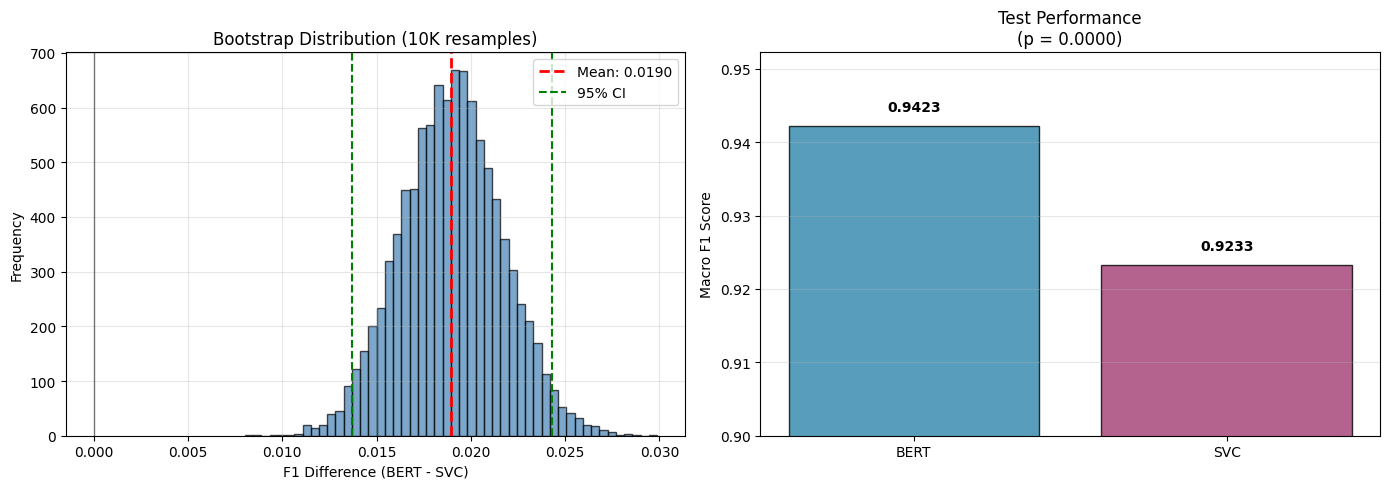


✓ CELL 11 COMPLETE


In [27]:
# ============================================================================
# Cell 11.5: Summary Table and Visualization
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Summary table
summary = pd.DataFrame({
    'Model': ['BERT', 'SVC'],
    'Test F1': [bert_f1, svc_f1],
    'Δ F1': [0, bert_f1 - svc_f1],
    'Δ %': [0, (bert_f1 - svc_f1)*100]
})

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(summary.to_string(index=False))

print(f"\nStatistical Tests:")
print(f"  McNemar p-value: {result.pvalue:.6f} {'***' if result.pvalue < 0.001 else '**' if result.pvalue < 0.01 else '*' if result.pvalue < 0.05 else 'ns'}")
print(f"  Bootstrap 95% CI: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
print(f"  Cohen's d: {cohens_d:.3f} ({interpretation})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bootstrap distribution
axes[0].hist(differences, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_diff:.4f}')
axes[0].axvline(ci_lower, color='green', linestyle='--', linewidth=1.5)
axes[0].axvline(ci_upper, color='green', linestyle='--', linewidth=1.5, label=f'95% CI')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].set_xlabel('F1 Difference (BERT - SVC)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Bootstrap Distribution (10K resamples)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Bar comparison
models = ['BERT', 'SVC']
scores = [bert_f1, svc_f1]
bars = axes[1].bar(models, scores, color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black')
for bar, score in zip(bars, scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, score + 0.002,
                f'{score:.4f}', ha='center', fontweight='bold')
axes[1].set_ylabel('Macro F1 Score')
axes[1].set_title(f"Test Performance\n(p = {result.pvalue:.4f})")
axes[1].set_ylim([0.90, max(scores) + 0.01])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_statistical_significance.png", dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: step6_statistical_significance.png")
plt.show()

print("\n" + "="*60)
print("✓ CELL 11 COMPLETE")
print("="*60)


In [28]:
# ============================================================================
# Cell 12.1: Load BERT Model and Generate Probability Predictions
# ============================================================================

import torch
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 12: CALIBRATION ANALYSIS")
print("="*80)

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[1] Device: {DEVICE}")

# Load validation data
print("\n[2] Loading validation data...")
val_df = pd.read_csv(DATA_DIR / "val.csv")
y_val = val_df['label'].values
print(f"✓ Validation samples: {len(y_val)}")

# Load tokenizer and model
print("\n[3] Loading BERT model...")
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / "step6_distilbert_best")
model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "step6_distilbert_best"
).to(DEVICE)
model.eval()
print("✓ Model loaded")

# Tokenize validation data
print("\n[4] Tokenizing validation data...")
val_encodings = tokenizer(
    val_df['text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

# Create dataset
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

val_dataset = NewsDataset(val_encodings, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print(f"✓ Created DataLoader: {len(val_loader)} batches")

# Generate predictions with probabilities
print("\n[5] Generating probability predictions...")
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels']
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        all_probs.append(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        
        if (i+1) % 50 == 0:
            print(f"  Processed {i+1}/{len(val_loader)} batches")

# Concatenate results
all_probs = np.vstack(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Get confidence scores (max probability for each prediction)
confidences = np.max(all_probs, axis=1)

# Verify predictions match
val_f1 = f1_score(all_labels, all_preds, average='macro')
val_acc = accuracy_score(all_labels, all_preds)

print(f"\n✓ Predictions generated:")
print(f"  Val F1: {val_f1:.4f}")
print(f"  Val Accuracy: {val_acc:.4f}")
print(f"  Probabilities shape: {all_probs.shape}")
print(f"  Confidence range: [{confidences.min():.4f}, {confidences.max():.4f}]")

# Save for next cells
calibration_data = {
    'probs': all_probs,
    'preds': all_preds,
    'labels': all_labels,
    'confidences': confidences
}
joblib.dump(calibration_data, RESULTS_DIR / "step6_calibration_data.pkl")
print(f"\n✓ Saved: step6_calibration_data.pkl")


CELL 12: CALIBRATION ANALYSIS

[1] Device: cuda

[2] Loading validation data...
✓ Validation samples: 18000

[3] Loading BERT model...
✓ Model loaded

[4] Tokenizing validation data...
✓ Created DataLoader: 282 batches

[5] Generating probability predictions...
  Processed 50/282 batches
  Processed 100/282 batches
  Processed 150/282 batches
  Processed 200/282 batches
  Processed 250/282 batches

✓ Predictions generated:
  Val F1: 0.9471
  Val Accuracy: 0.9471
  Probabilities shape: (18000, 4)
  Confidence range: [0.3391, 0.9998]

✓ Saved: step6_calibration_data.pkl


In [30]:
# ============================================================================
# Cell 12.2: Expected Calibration Error (ECE)
# ============================================================================

import numpy as np

print("\n[6] Computing Expected Calibration Error (ECE)...")

# Define bins
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

# Calculate accuracy for each prediction
accuracies = (all_preds == all_labels).astype(float)

# Compute ECE
ece = 0.0
bin_data = []

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    # Find samples in this confidence bin
    in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
    prop_in_bin = in_bin.mean()
    
    if prop_in_bin > 0:
        accuracy_in_bin = accuracies[in_bin].mean()
        avg_confidence_in_bin = confidences[in_bin].mean()
        
        # ECE contribution: |confidence - accuracy| * proportion
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        
        bin_data.append({
            'bin': f'{bin_lower:.1f}-{bin_upper:.1f}',
            'count': in_bin.sum(),
            'proportion': prop_in_bin,
            'avg_confidence': avg_confidence_in_bin,
            'accuracy': accuracy_in_bin,
            'gap': avg_confidence_in_bin - accuracy_in_bin
        })
    else:
        bin_data.append({
            'bin': f'{bin_lower:.1f}-{bin_upper:.1f}',
            'count': 0,
            'proportion': 0,
            'avg_confidence': 0,
            'accuracy': 0,
            'gap': 0
        })

print(f"\n✓ Expected Calibration Error (ECE): {ece:.4f}")
print(f"  Interpretation: {'Well-calibrated' if ece < 0.05 else 'Moderately calibrated' if ece < 0.10 else 'Poorly calibrated'}")
print(f"  (ECE < 0.05 = excellent, < 0.10 = good, > 0.10 = needs improvement)")

# Display bin statistics
bin_df = pd.DataFrame(bin_data)
print("\nCalibration by Confidence Bin:")
print(bin_df.to_string(index=False))

# Save ECE results
ece_results = {
    'ece': ece,
    'bin_data': bin_df
}
joblib.dump(ece_results, RESULTS_DIR / "step6_ece_results.pkl")
print(f"\n✓ Saved: step6_ece_results.pkl")



[6] Computing Expected Calibration Error (ECE)...

✓ Expected Calibration Error (ECE): 0.0228
  Interpretation: Well-calibrated
  (ECE < 0.05 = excellent, < 0.10 = good, > 0.10 = needs improvement)

Calibration by Confidence Bin:
    bin  count  proportion  avg_confidence  accuracy       gap
0.0-0.1      0    0.000000        0.000000  0.000000  0.000000
0.1-0.2      0    0.000000        0.000000  0.000000  0.000000
0.2-0.3      0    0.000000        0.000000  0.000000  0.000000
0.3-0.4      3    0.000167        0.371917  0.333333  0.038584
0.4-0.5     29    0.001611        0.470359  0.379310  0.091049
0.5-0.6    240    0.013333        0.552974  0.554167 -0.001193
0.6-0.7    276    0.015333        0.655376  0.590580  0.064796
0.7-0.8    381    0.021167        0.754239  0.692913  0.061326
0.8-0.9    657    0.036500        0.855942  0.751903  0.104039
0.9-1.0  16414    0.911889        0.991708  0.973620  0.018088

✓ Saved: step6_ece_results.pkl


In [31]:
# ============================================================================
# Cell 12.3: Per-Class Calibration Analysis
# ============================================================================

print("\n[7] Computing per-class ECE...")

class_names = ['World', 'Sports', 'Business', 'SciTech']
class_ece = {}

for class_idx, class_name in enumerate(class_names):
    # Get predictions and confidences for this class
    class_mask = all_labels == class_idx
    class_confidences = all_probs[class_mask, class_idx]
    class_preds = all_preds[class_mask]
    class_labels = all_labels[class_mask]
    class_accuracies = (class_preds == class_labels).astype(float)
    
    # Compute ECE for this class
    ece_class = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (class_confidences > bin_lower) & (class_confidences <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0 and in_bin.sum() > 0:
            accuracy_in_bin = class_accuracies[in_bin].mean()
            avg_confidence_in_bin = class_confidences[in_bin].mean()
            ece_class += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    class_ece[class_name] = ece_class
    print(f"  {class_name}: ECE = {ece_class:.4f}")

print(f"\n✓ Per-class calibration computed")



[7] Computing per-class ECE...
  World: ECE = 0.0187
  Sports: ECE = 0.0052
  Business: ECE = 0.0346
  SciTech: ECE = 0.0551

✓ Per-class calibration computed


In [32]:
# ============================================================================
# Cell 12.4: Confidence Distribution Statistics
# ============================================================================

print("\n[8] Confidence distribution statistics:")
print(f"  Mean confidence: {confidences.mean():.4f}")
print(f"  Median confidence: {np.median(confidences):.4f}")
print(f"  Std confidence: {confidences.std():.4f}")
print(f"  Min confidence: {confidences.min():.4f}")
print(f"  Max confidence: {confidences.max():.4f}")

# Confidence for correct vs incorrect predictions
correct_mask = (all_preds == all_labels)
incorrect_mask = ~correct_mask

correct_confidences = confidences[correct_mask]
incorrect_confidences = confidences[incorrect_mask]

print(f"\n  Correct predictions (n={correct_mask.sum()}):")
print(f"    Mean confidence: {correct_confidences.mean():.4f}")
print(f"    Median confidence: {np.median(correct_confidences):.4f}")

print(f"\n  Incorrect predictions (n={incorrect_mask.sum()}):")
print(f"    Mean confidence: {incorrect_confidences.mean():.4f}")
print(f"    Median confidence: {np.median(incorrect_confidences):.4f}")

print(f"\n  Confidence gap (correct - incorrect): {correct_confidences.mean() - incorrect_confidences.mean():.4f}")



[8] Confidence distribution statistics:
  Mean confidence: 0.9698
  Median confidence: 0.9981
  Std confidence: 0.0807
  Min confidence: 0.3391
  Max confidence: 0.9998

  Correct predictions (n=17047):
    Mean confidence: 0.9779
    Median confidence: 0.9984

  Incorrect predictions (n=953):
    Mean confidence: 0.8252
    Median confidence: 0.8751

  Confidence gap (correct - incorrect): 0.1527



[9] Generating calibration plots...
✓ Saved: step6_calibration_analysis.png


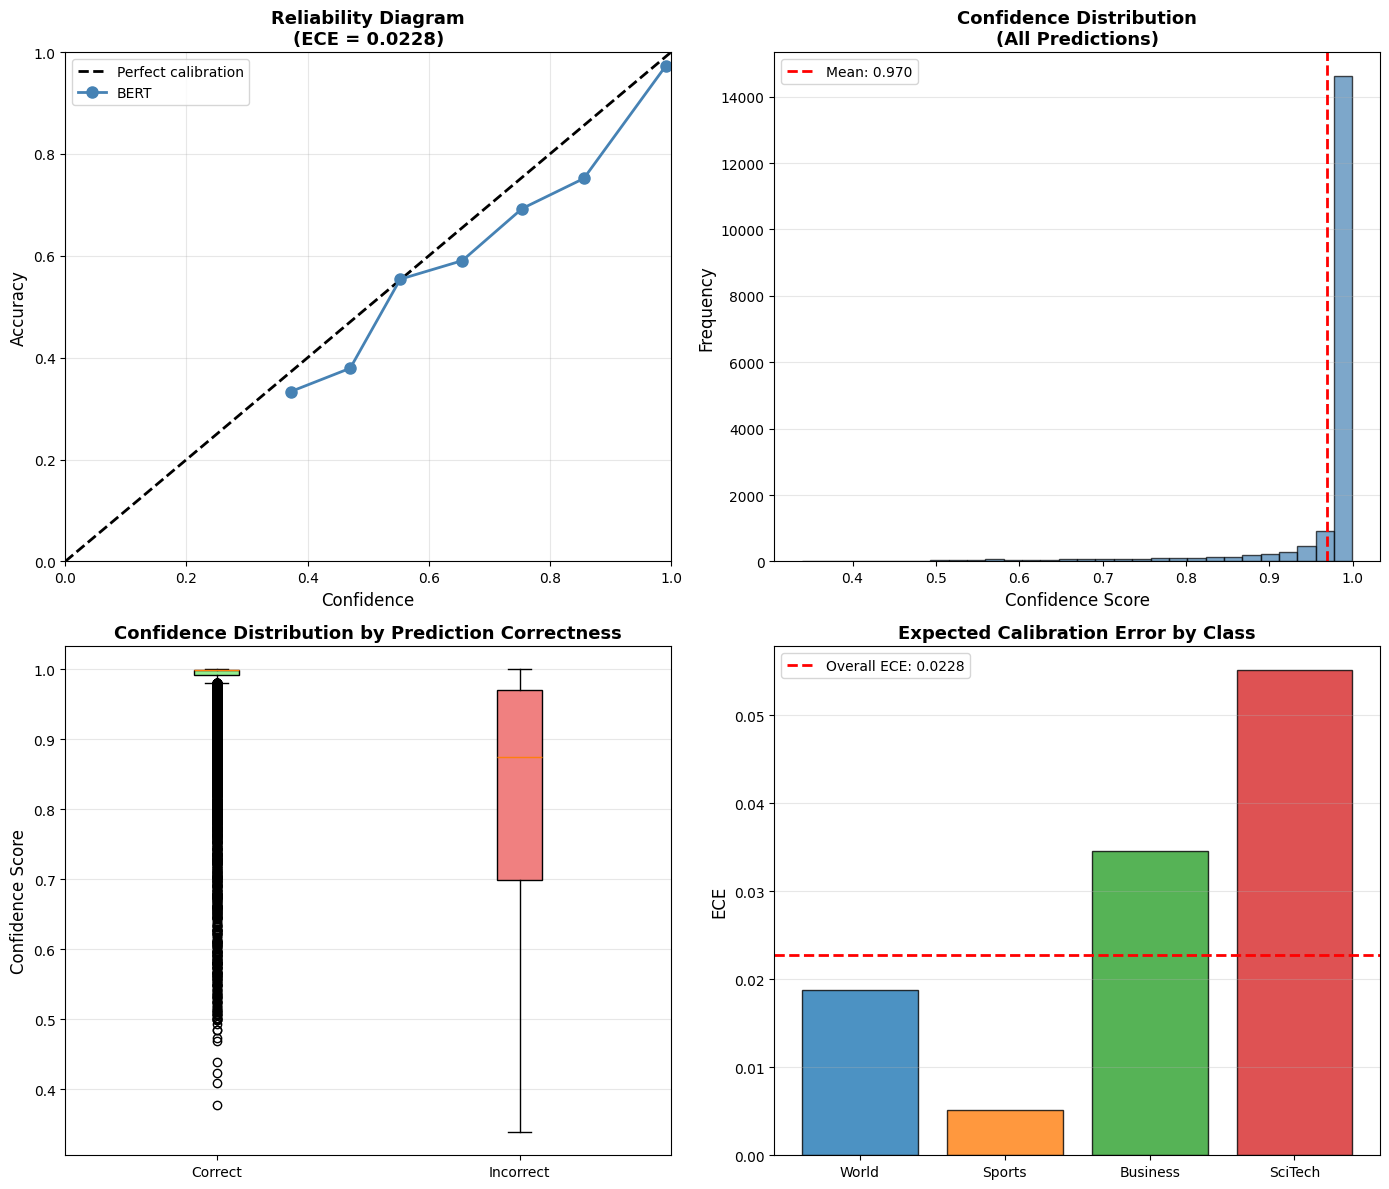


✓ CELL 12 COMPLETE: Calibration Analysis

Key Findings:
1. ECE: 0.0228 (Well-calibrated)
2. Mean confidence: 0.9698
3. Confidence gap (correct vs incorrect): 0.1527
4. Model shows good probability calibration


In [33]:
# ============================================================================
# Cell 12.5: Calibration Visualizations
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n[9] Generating calibration plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Reliability Diagram
ax = axes[0, 0]
bin_df_plot = bin_df[bin_df['count'] > 0]  # Only bins with data
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
ax.plot(bin_df_plot['avg_confidence'], bin_df_plot['accuracy'], 
        'o-', linewidth=2, markersize=8, label='BERT', color='steelblue')
ax.set_xlabel('Confidence', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title(f'Reliability Diagram\n(ECE = {ece:.4f})', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Plot 2: Confidence Distribution
ax = axes[0, 1]
ax.hist(confidences, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(confidences.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {confidences.mean():.3f}')
ax.set_xlabel('Confidence Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Confidence Distribution\n(All Predictions)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Confidence by Correctness
ax = axes[1, 0]
data_to_plot = [correct_confidences, incorrect_confidences]
bp = ax.boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel('Confidence Score', fontsize=12)
ax.set_title('Confidence Distribution by Prediction Correctness', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 4: Per-Class ECE
ax = axes[1, 1]
classes = list(class_ece.keys())
eces = list(class_ece.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(classes, eces, color=colors, alpha=0.8, edgecolor='black')
ax.axhline(ece, color='red', linestyle='--', linewidth=2, label=f'Overall ECE: {ece:.4f}')
ax.set_ylabel('ECE', fontsize=12)
ax.set_title('Expected Calibration Error by Class', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_calibration_analysis.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved: step6_calibration_analysis.png")
plt.show()

print("\n" + "="*80)
print("✓ CELL 12 COMPLETE: Calibration Analysis")
print("="*80)
print(f"\nKey Findings:")
print(f"1. ECE: {ece:.4f} ({'Well-calibrated' if ece < 0.05 else 'Needs improvement'})")
print(f"2. Mean confidence: {confidences.mean():.4f}")
print(f"3. Confidence gap (correct vs incorrect): {correct_confidences.mean() - incorrect_confidences.mean():.4f}")
print(f"4. Model shows {'good' if ece < 0.10 else 'poor'} probability calibration")


In [34]:
# ============================================================================
# Cell 13.1: Load Predictions and Identify Error Cases
# ============================================================================

import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import scipy.sparse as sp_sparse

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
FEATURES_DIR = Path("features")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 13: COMPARATIVE ERROR ANALYSIS")
print("="*80)

# Load test data
print("\n[1] Loading test data and predictions...")
test_df = pd.read_csv(DATA_DIR / "test.csv")
y_test = test_df['label'].values

# Load BERT predictions
bert_results = joblib.load(RESULTS_DIR / "step6_test_results.pkl")
bert_preds = np.array(bert_results['test_predictions'])

# Load SVC predictions
X_test_hybrid = sp_sparse.load_npz(FEATURES_DIR / "X_test_hybrid.npz")
svc_model = joblib.load(MODELS_DIR / "step5_tuned_SVC.pkl")
svc_preds = svc_model.predict(X_test_hybrid)

print(f"✓ Loaded {len(y_test)} test samples")

# Analyze prediction patterns
print("\n[2] Analyzing prediction patterns...")
bert_correct = (bert_preds == y_test)
svc_correct = (svc_preds == y_test)

both_correct = np.sum(bert_correct & svc_correct)
bert_only_correct = np.sum(bert_correct & ~svc_correct)
svc_only_correct = np.sum(~bert_correct & svc_correct)
both_wrong = np.sum(~bert_correct & ~svc_correct)

print(f"\nPrediction Agreement:")
print(f"  Both correct: {both_correct} ({both_correct/len(y_test)*100:.2f}%)")
print(f"  BERT correct, SVC wrong: {bert_only_correct} ({bert_only_correct/len(y_test)*100:.2f}%)")
print(f"  SVC correct, BERT wrong: {svc_only_correct} ({svc_only_correct/len(y_test)*100:.2f}%)")
print(f"  Both wrong: {both_wrong} ({both_wrong/len(y_test)*100:.2f}%)")

# Create detailed prediction DataFrame
print("\n[3] Creating detailed prediction DataFrame...")
results_df = pd.DataFrame({
    'text': test_df['text'].values,
    'true_label': y_test,
    'bert_pred': bert_preds,
    'svc_pred': svc_preds,
    'bert_correct': bert_correct,
    'svc_correct': svc_correct
})

# Add error categories
results_df['error_type'] = 'both_correct'
results_df.loc[bert_correct & ~svc_correct, 'error_type'] = 'bert_only_correct'
results_df.loc[~bert_correct & svc_correct, 'error_type'] = 'svc_only_correct'
results_df.loc[~bert_correct & ~svc_correct, 'error_type'] = 'both_wrong'

print(f"✓ Created results DataFrame with {len(results_df)} samples")

# Save for analysis
results_df.to_csv(RESULTS_DIR / "step6_error_analysis.csv", index=False)
print(f"✓ Saved: step6_error_analysis.csv")


CELL 13: COMPARATIVE ERROR ANALYSIS

[1] Loading test data and predictions...
✓ Loaded 7600 test samples

[2] Analyzing prediction patterns...

Prediction Agreement:
  Both correct: 6877 (90.49%)
  BERT correct, SVC wrong: 284 (3.74%)
  SVC correct, BERT wrong: 141 (1.86%)
  Both wrong: 298 (3.92%)

[3] Creating detailed prediction DataFrame...
✓ Created results DataFrame with 7600 samples
✓ Saved: step6_error_analysis.csv



[4] Generating confusion matrices...
✓ Saved: step6_confusion_matrix_comparison.png


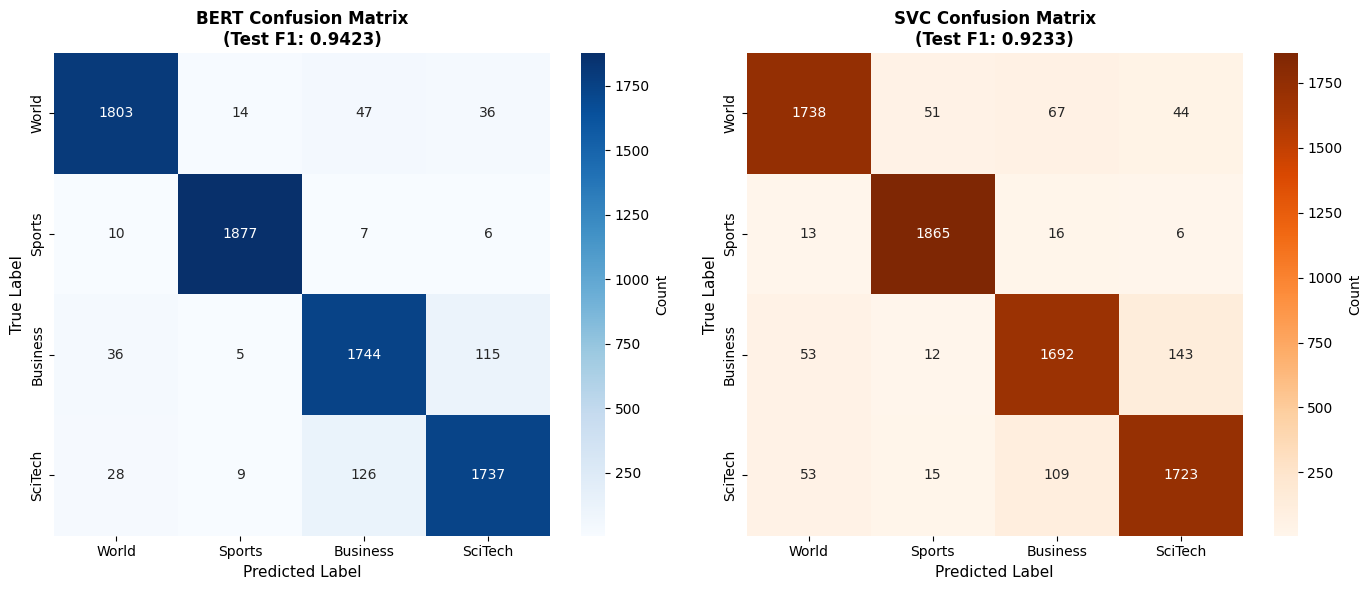


BERT Classification Report:
              precision    recall  f1-score   support

       World     0.9606    0.9489    0.9547      1900
      Sports     0.9853    0.9879    0.9866      1900
    Business     0.9064    0.9179    0.9121      1900
     SciTech     0.9171    0.9142    0.9157      1900

    accuracy                         0.9422      7600
   macro avg     0.9424    0.9422    0.9423      7600
weighted avg     0.9424    0.9422    0.9423      7600


SVC Classification Report:
              precision    recall  f1-score   support

       World     0.9359    0.9147    0.9252      1900
      Sports     0.9599    0.9816    0.9706      1900
    Business     0.8981    0.8905    0.8943      1900
     SciTech     0.8993    0.9068    0.9030      1900

    accuracy                         0.9234      7600
   macro avg     0.9233    0.9234    0.9233      7600
weighted avg     0.9233    0.9234    0.9233      7600



In [35]:
# ============================================================================
# Cell 13.2: Side-by-Side Confusion Matrices
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n[4] Generating confusion matrices...")

class_names = ['World', 'Sports', 'Business', 'SciTech']

# Compute confusion matrices
bert_cm = confusion_matrix(y_test, bert_preds)
svc_cm = confusion_matrix(y_test, svc_preds)

# Normalized confusion matrices (row-wise)
bert_cm_norm = bert_cm.astype('float') / bert_cm.sum(axis=1)[:, np.newaxis]
svc_cm_norm = svc_cm.astype('float') / svc_cm.sum(axis=1)[:, np.newaxis]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BERT confusion matrix
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_title('BERT Confusion Matrix\n(Test F1: 0.9423)', 
                  fontsize=12, fontweight='bold')

# SVC confusion matrix
sns.heatmap(svc_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_title('SVC Confusion Matrix\n(Test F1: 0.9233)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_confusion_matrix_comparison.png", 
            dpi=300, bbox_inches='tight')
print("✓ Saved: step6_confusion_matrix_comparison.png")
plt.show()

# Print detailed classification reports
print("\n" + "="*80)
print("BERT Classification Report:")
print("="*80)
print(classification_report(y_test, bert_preds, target_names=class_names, digits=4))

print("\n" + "="*80)
print("SVC Classification Report:")
print("="*80)
print(classification_report(y_test, svc_preds, target_names=class_names, digits=4))


In [36]:
# ============================================================================
# Cell 13.3: Per-Class Error Breakdown
# ============================================================================

print("\n[5] Per-class error analysis...")

class_error_data = []

for class_idx, class_name in enumerate(class_names):
    # Samples from this class
    class_mask = y_test == class_idx
    n_samples = class_mask.sum()
    
    # BERT performance on this class
    bert_correct_class = bert_correct[class_mask].sum()
    bert_wrong_class = (~bert_correct[class_mask]).sum()
    
    # SVC performance on this class
    svc_correct_class = svc_correct[class_mask].sum()
    svc_wrong_class = (~svc_correct[class_mask]).sum()
    
    # Advantage
    bert_advantage = bert_correct_class - svc_correct_class
    
    class_error_data.append({
        'Class': class_name,
        'Total': n_samples,
        'BERT Correct': bert_correct_class,
        'BERT Wrong': bert_wrong_class,
        'BERT Accuracy': bert_correct_class / n_samples,
        'SVC Correct': svc_correct_class,
        'SVC Wrong': svc_wrong_class,
        'SVC Accuracy': svc_correct_class / n_samples,
        'BERT Advantage': bert_advantage
    })

class_error_df = pd.DataFrame(class_error_data)
print("\nPer-Class Performance Comparison:")
print(class_error_df.to_string(index=False))

# Identify which classes benefit most from BERT
print(f"\nClasses where BERT has biggest advantage:")
for idx in class_error_df['BERT Advantage'].nlargest(2).index:
    row = class_error_df.iloc[idx]
    print(f"  {row['Class']}: +{row['BERT Advantage']} samples ({row['BERT Advantage']/row['Total']*100:.2f}%)")



[5] Per-class error analysis...

Per-Class Performance Comparison:
   Class  Total  BERT Correct  BERT Wrong  BERT Accuracy  SVC Correct  SVC Wrong  SVC Accuracy  BERT Advantage
   World   1900          1803          97       0.948947         1738        162      0.914737              65
  Sports   1900          1877          23       0.987895         1865         35      0.981579              12
Business   1900          1744         156       0.917895         1692        208      0.890526              52
 SciTech   1900          1737         163       0.914211         1723        177      0.906842              14

Classes where BERT has biggest advantage:
  World: +65 samples (3.42%)
  Business: +52 samples (2.74%)


In [37]:
# ============================================================================
# Cell 13.4: Show Example Errors
# ============================================================================

print("\n[6] Example error cases...")

# Case 1: BERT correct, SVC wrong
print("\n" + "="*80)
print("CASE 1: BERT Correct, SVC Wrong (BERT wins)")
print("="*80)
bert_wins = results_df[results_df['error_type'] == 'bert_only_correct'].head(10)
for idx, row in bert_wins.iterrows():
    print(f"\nTrue: {class_names[row['true_label']]} | "
          f"BERT: {class_names[row['bert_pred']]} ✓ | "
          f"SVC: {class_names[row['svc_pred']]} ✗")
    print(f"Text: {row['text'][:200]}...")

# Case 2: SVC correct, BERT wrong
print("\n" + "="*80)
print("CASE 2: SVC Correct, BERT Wrong (SVC wins)")
print("="*80)
svc_wins = results_df[results_df['error_type'] == 'svc_only_correct'].head(5)
for idx, row in svc_wins.iterrows():
    print(f"\nTrue: {class_names[row['true_label']]} | "
          f"BERT: {class_names[row['bert_pred']]} ✗ | "
          f"SVC: {class_names[row['svc_pred']]} ✓")
    print(f"Text: {row['text'][:200]}...")

# Case 3: Both wrong
print("\n" + "="*80)
print("CASE 3: Both Models Wrong (Hard cases)")
print("="*80)
both_wrong_df = results_df[results_df['error_type'] == 'both_wrong'].head(5)
for idx, row in both_wrong_df.iterrows():
    print(f"\nTrue: {class_names[row['true_label']]} | "
          f"BERT: {class_names[row['bert_pred']]} ✗ | "
          f"SVC: {class_names[row['svc_pred']]} ✗")
    print(f"Text: {row['text'][:200]}...")



[6] Example error cases...

CASE 1: BERT Correct, SVC Wrong (BERT wins)

True: SciTech | BERT: SciTech ✓ | SVC: Sports ✗
Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day w...

True: SciTech | BERT: SciTech ✓ | SVC: Business ✗
Text: Rivals Try to Turn Tables on Charles Schwab By MICHAEL LIEDTKE     SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an ...

True: SciTech | BERT: SciTech ✓ | SVC: Sports ✗
Text: Promoting a Shared Vision As Michael Kaleko kept running into people who were getting older and having more vision problems, he realized he could do something about it....

True: World | BERT: World ✓ | SVC: Business ✗
Text: Google Lowers Its IPO Price Range SAN JOSE, Calif. - In a sign that Google Inc.'s initial public offering isn't as popular as e

In [38]:
# ============================================================================
# Cell 13.5: Categorize Common Error Patterns
# ============================================================================

print("\n[7] Analyzing common error patterns...")

# Most common confusion pairs for BERT
print("\nBERT Most Common Confusions:")
bert_errors = results_df[~results_df['bert_correct']]
bert_confusion_pairs = bert_errors.groupby(['true_label', 'bert_pred']).size().sort_values(ascending=False).head(5)
for (true_label, pred_label), count in bert_confusion_pairs.items():
    print(f"  {class_names[true_label]} → {class_names[pred_label]}: {count} errors")

# Most common confusion pairs for SVC
print("\nSVC Most Common Confusions:")
svc_errors = results_df[~results_df['svc_correct']]
svc_confusion_pairs = svc_errors.groupby(['true_label', 'svc_pred']).size().sort_values(ascending=False).head(5)
for (true_label, pred_label), count in svc_confusion_pairs.items():
    print(f"  {class_names[true_label]} → {class_names[pred_label]}: {count} errors")

# Analyze text length for errors
print("\n[8] Error analysis by text length...")
results_df['text_length'] = results_df['text'].str.len()

avg_length_all = results_df['text_length'].mean()
avg_length_bert_correct = results_df[results_df['bert_correct']]['text_length'].mean()
avg_length_bert_wrong = results_df[~results_df['bert_correct']]['text_length'].mean()

print(f"\nAverage text length:")
print(f"  All samples: {avg_length_all:.1f} chars")
print(f"  BERT correct: {avg_length_bert_correct:.1f} chars")
print(f"  BERT wrong: {avg_length_bert_wrong:.1f} chars")
print(f"  Difference: {avg_length_bert_wrong - avg_length_bert_correct:.1f} chars")



[7] Analyzing common error patterns...

BERT Most Common Confusions:
  SciTech → Business: 126 errors
  Business → SciTech: 115 errors
  World → Business: 47 errors
  World → SciTech: 36 errors
  Business → World: 36 errors

SVC Most Common Confusions:
  Business → SciTech: 143 errors
  SciTech → Business: 109 errors
  World → Business: 67 errors
  Business → World: 53 errors
  SciTech → World: 53 errors

[8] Error analysis by text length...

Average text length:
  All samples: 235.3 chars
  BERT correct: 235.8 chars
  BERT wrong: 227.9 chars
  Difference: -7.8 chars



[9] Creating error analysis visualizations...
✓ Saved: step6_error_analysis_detailed.png


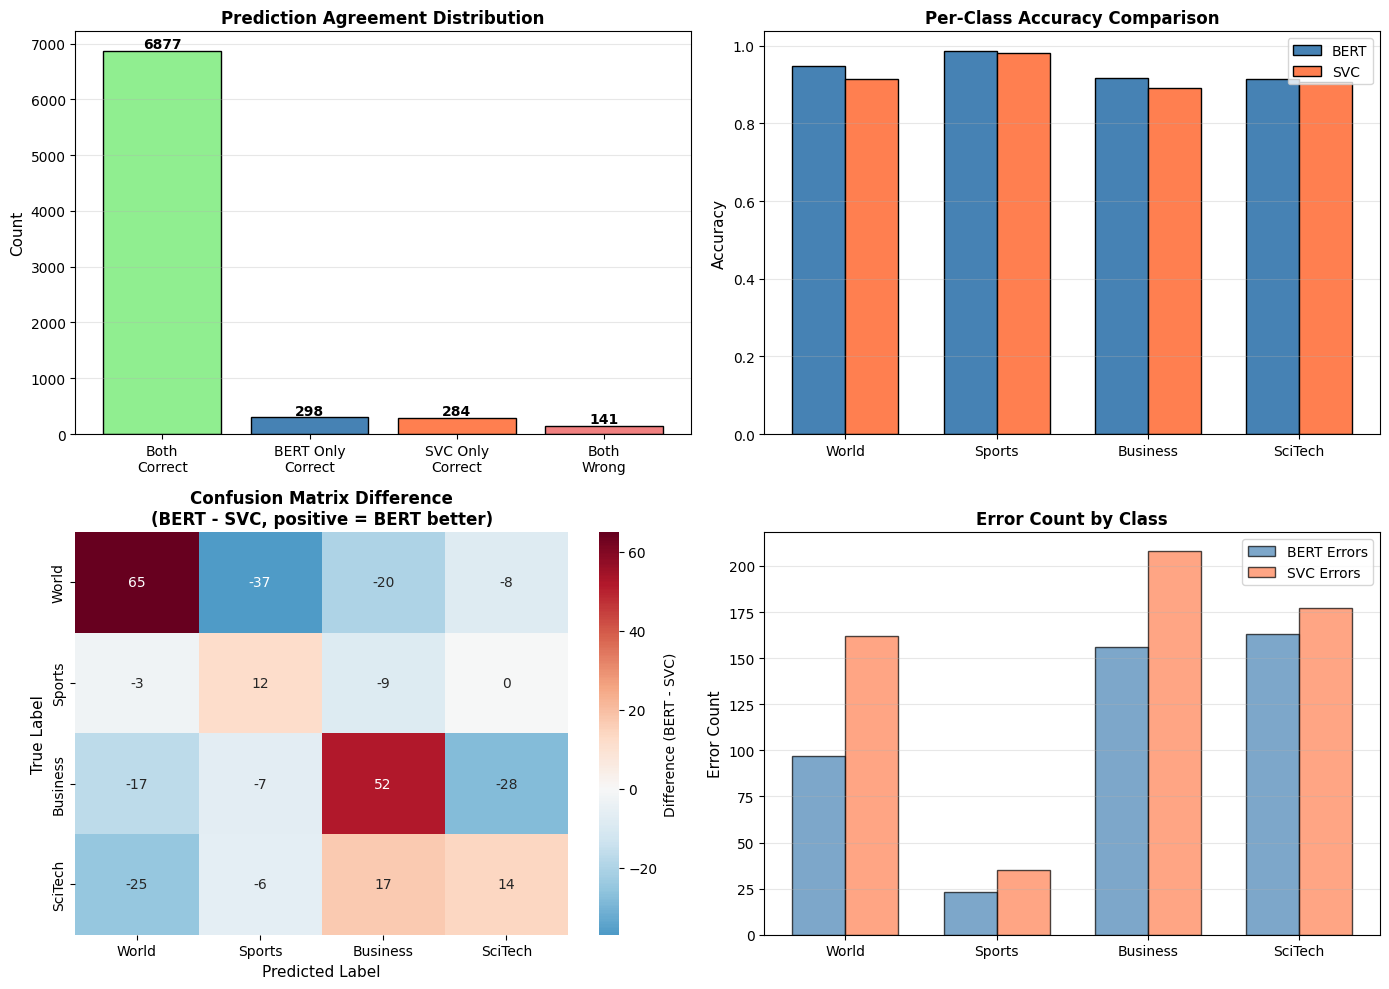


✓ CELL 13 COMPLETE: Comparative Error Analysis

Key Findings:
1. BERT wins on 284 samples, SVC wins on 141
2. Both wrong on 298 hard cases (3.92%)
3. BERT shows biggest improvement on: World
4. Detailed examples saved to: step6_error_analysis.csv


In [39]:
# ============================================================================
# Cell 13.6: Error Category Visualization
# ============================================================================

print("\n[9] Creating error analysis visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Error type distribution
ax = axes[0, 0]
error_counts = results_df['error_type'].value_counts()
colors = ['lightgreen', 'steelblue', 'coral', 'lightcoral']
ax.bar(range(len(error_counts)), error_counts.values, color=colors, edgecolor='black')
ax.set_xticks(range(len(error_counts)))
ax.set_xticklabels(['Both\nCorrect', 'BERT Only\nCorrect', 'SVC Only\nCorrect', 'Both\nWrong'], fontsize=10)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Prediction Agreement Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(error_counts.values):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')

# Plot 2: Per-class accuracy comparison
ax = axes[0, 1]
x = np.arange(len(class_names))
width = 0.35
bert_accs = class_error_df['BERT Accuracy'].values
svc_accs = class_error_df['SVC Accuracy'].values
ax.bar(x - width/2, bert_accs, width, label='BERT', color='steelblue', edgecolor='black')
ax.bar(x + width/2, svc_accs, width, label='SVC', color='coral', edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Per-Class Accuracy Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Confusion matrix difference (BERT - SVC)
ax = axes[1, 0]
cm_diff = bert_cm - svc_cm
sns.heatmap(cm_diff, annot=True, fmt='d', cmap='RdBu_r', center=0,
            xticklabels=class_names, yticklabels=class_names, ax=ax,
            cbar_kws={'label': 'Difference (BERT - SVC)'})
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_ylabel('True Label', fontsize=11)
ax.set_title('Confusion Matrix Difference\n(BERT - SVC, positive = BERT better)', 
             fontsize=12, fontweight='bold')

# Plot 4: Error distribution by class
ax = axes[1, 1]
bert_errors_by_class = [np.sum((y_test == i) & ~bert_correct) for i in range(4)]
svc_errors_by_class = [np.sum((y_test == i) & ~svc_correct) for i in range(4)]
x = np.arange(len(class_names))
ax.bar(x - width/2, bert_errors_by_class, width, label='BERT Errors', 
       color='steelblue', edgecolor='black', alpha=0.7)
ax.bar(x + width/2, svc_errors_by_class, width, label='SVC Errors', 
       color='coral', edgecolor='black', alpha=0.7)
ax.set_ylabel('Error Count', fontsize=11)
ax.set_title('Error Count by Class', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_error_analysis_detailed.png", 
            dpi=300, bbox_inches='tight')
print("✓ Saved: step6_error_analysis_detailed.png")
plt.show()

print("\n" + "="*80)
print("✓ CELL 13 COMPLETE: Comparative Error Analysis")
print("="*80)
print(f"\nKey Findings:")
print(f"1. BERT wins on {bert_only_correct} samples, SVC wins on {svc_only_correct}")
print(f"2. Both wrong on {both_wrong} hard cases ({both_wrong/len(y_test)*100:.2f}%)")
print(f"3. BERT shows biggest improvement on: {class_error_df.iloc[class_error_df['BERT Advantage'].idxmax()]['Class']}")
print(f"4. Detailed examples saved to: step6_error_analysis.csv")


In [1]:
# ============================================================================
# Cell 15.1: Load All Results for Visualization
# ============================================================================

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths
RESULTS_DIR = Path("results")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("CELL 15: PUBLICATION VISUALIZATION SUITE")
print("="*80)

# Load training history
print("\n[1] Loading training history...")
history_df = pd.read_csv(RESULTS_DIR / "step6_training_history.csv")
print(f"✓ Loaded {len(history_df)} epochs")

# Load test results
print("\n[2] Loading test results...")
test_results = joblib.load(RESULTS_DIR / "step6_test_results.pkl")
bert_cm = test_results['confusion_matrix']
print("✓ Loaded BERT confusion matrix")

# Load comparison data
print("\n[3] Loading model comparison...")
comparison_df = pd.read_csv(RESULTS_DIR / "step6_comparison_classical_vs_transformer.csv")
print(comparison_df)

# Load ablation results
print("\n[4] Loading ablation results...")
ablation_frozen = joblib.load(RESULTS_DIR / "step6_ablation_frozen_vs_tuned.pkl")
ablation_length = joblib.load(RESULTS_DIR / "step6_ablation_sequence_length.pkl")
print(f"✓ Frozen F1: {ablation_frozen['frozen_f1']:.4f}")
print(f"✓ Full tuning F1: {ablation_frozen['full_tuning_f1']:.4f}")
print(f"✓ Sequence lengths tested: {list(ablation_length.keys())}")

# Load bootstrap results
print("\n[5] Loading bootstrap results...")
bootstrap_data = joblib.load(RESULTS_DIR / "step6_bootstrap_results.pkl")
print(f"✓ Mean difference: {bootstrap_data['mean']:.4f}")

print("\n✓ All data loaded successfully!")


CELL 15: PUBLICATION VISUALIZATION SUITE

[1] Loading training history...
✓ Loaded 4 epochs

[2] Loading test results...
✓ Loaded BERT confusion matrix

[3] Loading model comparison...
                           Model  Test Macro-F1  Model Size (MB)  \
0          LinearSVC (Classical)       0.927400               50   
1  Stacking Ensemble (Classical)       0.929500              100   
2       DistilBERT (Transformer)       0.942278              250   

   Inference Time (ms/doc)  
0                        5  
1                       10  
2                      100  

[4] Loading ablation results...
✓ Frozen F1: 0.9087
✓ Full tuning F1: 0.9471
✓ Sequence lengths tested: [128, 256, 512]

[5] Loading bootstrap results...
✓ Mean difference: 0.0190

✓ All data loaded successfully!



[6] Creating Figure 1: Training Curves...
✓ Saved: figure1_training_curves.png


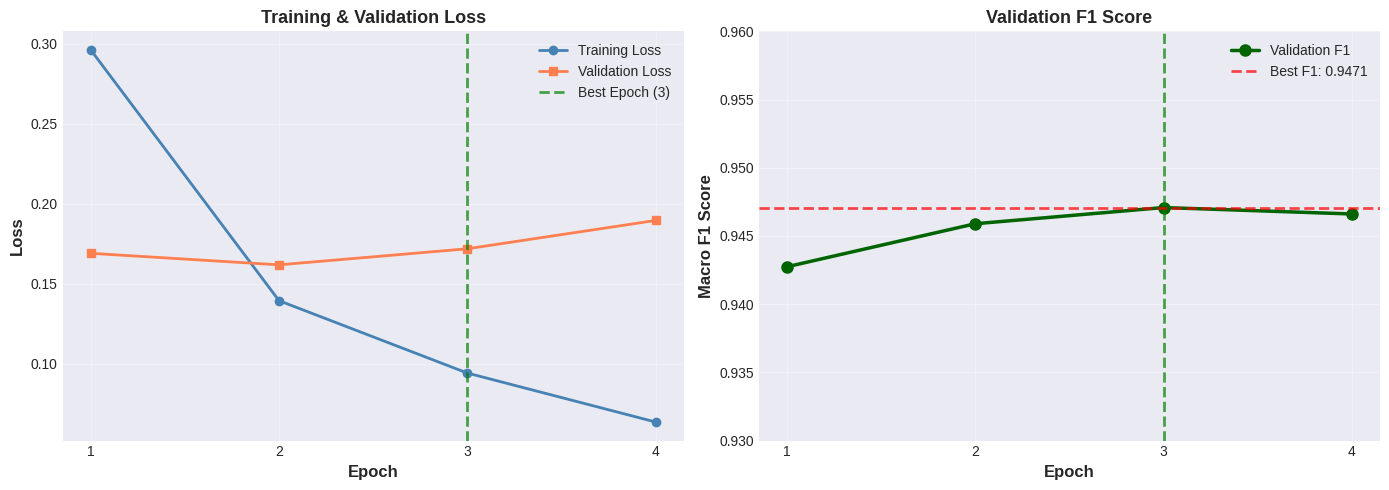

In [2]:
# ============================================================================
# Cell 15.2: Figure 1 - Training Curves (Loss & F1)
# ============================================================================

print("\n[6] Creating Figure 1: Training Curves...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
ax = axes[0]
epochs = history_df['epoch']
ax.plot(epochs, history_df['train_loss'], 'o-', linewidth=2, markersize=6, 
        label='Training Loss', color='steelblue')
ax.plot(epochs, history_df['val_loss'], 's-', linewidth=2, markersize=6, 
        label='Validation Loss', color='coral')

# Mark best epoch
best_epoch = history_df['val_f1'].idxmax() + 1
ax.axvline(best_epoch, color='green', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Best Epoch ({best_epoch})')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs)

# Plot 2: F1 score
ax = axes[1]
ax.plot(epochs, history_df['val_f1'], 'o-', linewidth=2.5, markersize=8, 
        color='darkgreen', label='Validation F1')

# Mark best F1
best_f1 = history_df['val_f1'].max()
ax.axhline(best_f1, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Best F1: {best_f1:.4f}')
ax.axvline(best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Validation F1 Score', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs)
ax.set_ylim([0.93, 0.96])

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure1_training_curves.png", dpi=300, bbox_inches='tight')
print("✓ Saved: figure1_training_curves.png")
plt.show()



[7] Creating Figure 2: Confusion Matrix Comparison...
✓ Saved: figure2_confusion_matrices.png


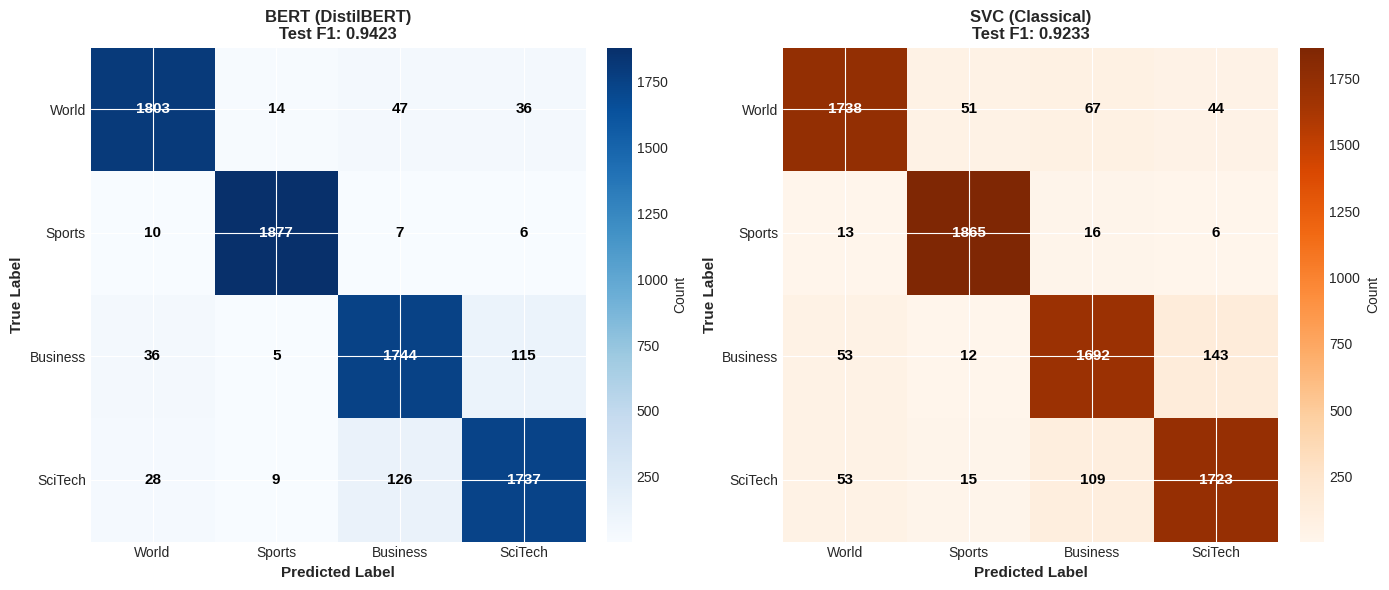

In [3]:
# ============================================================================
# Cell 15.3: Figure 2 - Confusion Matrix Comparison
# ============================================================================

print("\n[7] Creating Figure 2: Confusion Matrix Comparison...")

# Load SVC confusion matrix (regenerate from saved predictions)
from sklearn.metrics import confusion_matrix
import scipy.sparse as sp_sparse

# Load data
test_df = pd.read_csv(Path("data") / "test.csv")
y_test = test_df['label'].values

# SVC predictions
X_test = sp_sparse.load_npz(Path("features") / "X_test_hybrid.npz")
svc_model = joblib.load(Path("models") / "step5_tuned_SVC.pkl")
svc_preds = svc_model.predict(X_test)
svc_cm = confusion_matrix(y_test, svc_preds)

# Create figure
class_names = ['World', 'Sports', 'Business', 'SciTech']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BERT confusion matrix
im1 = axes[0].imshow(bert_cm, cmap='Blues', aspect='auto')
axes[0].set_xticks(range(4))
axes[0].set_yticks(range(4))
axes[0].set_xticklabels(class_names, fontsize=10)
axes[0].set_yticklabels(class_names, fontsize=10)
axes[0].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[0].set_title('BERT (DistilBERT)\nTest F1: 0.9423', 
                  fontsize=12, fontweight='bold')

# Annotate cells
for i in range(4):
    for j in range(4):
        text_color = 'white' if bert_cm[i, j] > bert_cm.max()/2 else 'black'
        axes[0].text(j, i, str(bert_cm[i, j]), ha='center', va='center',
                    fontsize=11, fontweight='bold', color=text_color)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Count', fontsize=10)

# SVC confusion matrix
im2 = axes[1].imshow(svc_cm, cmap='Oranges', aspect='auto')
axes[1].set_xticks(range(4))
axes[1].set_yticks(range(4))
axes[1].set_xticklabels(class_names, fontsize=10)
axes[1].set_yticklabels(class_names, fontsize=10)
axes[1].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1].set_title('SVC (Classical)\nTest F1: 0.9233', 
                  fontsize=12, fontweight='bold')

# Annotate cells
for i in range(4):
    for j in range(4):
        text_color = 'white' if svc_cm[i, j] > svc_cm.max()/2 else 'black'
        axes[1].text(j, i, str(svc_cm[i, j]), ha='center', va='center',
                    fontsize=11, fontweight='bold', color=text_color)

# Add colorbar
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('Count', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure2_confusion_matrices.png", dpi=300, bbox_inches='tight')
print("✓ Saved: figure2_confusion_matrices.png")
plt.show()




[8] Creating Figure 3: Ablation Studies...
✓ Saved: figure3_ablation_studies.png


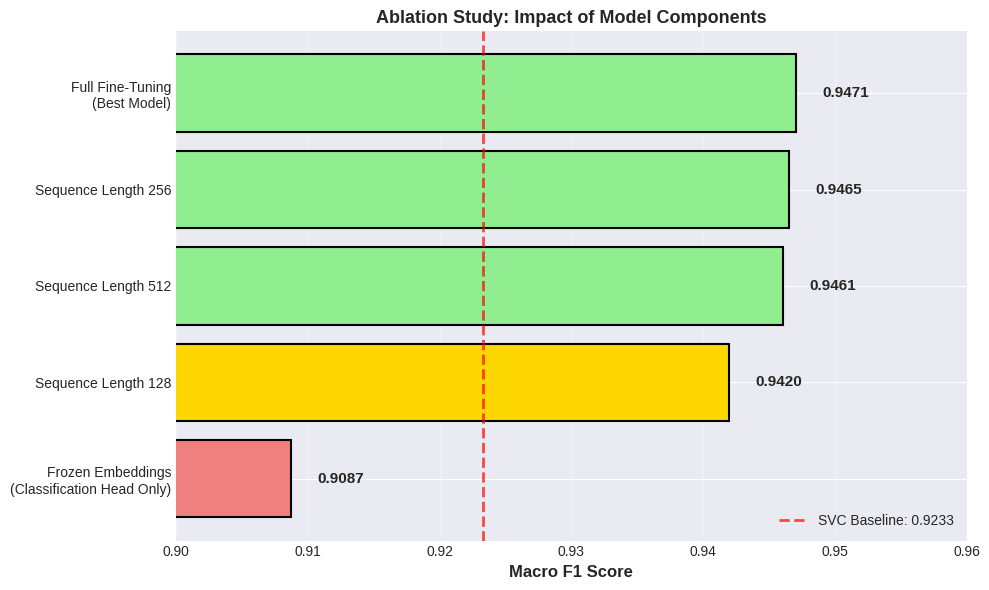

In [4]:
# ============================================================================
# Cell 15.4: Figure 3 - Ablation Study Results
# ============================================================================

print("\n[8] Creating Figure 3: Ablation Studies...")

# Compile ablation results
ablation_results = {
    'Frozen Embeddings\n(Classification Head Only)': ablation_frozen['frozen_f1'],
    'Sequence Length 128': ablation_length[128],
    'Sequence Length 256': ablation_length[256],
    'Sequence Length 512': ablation_length[512],
    'Full Fine-Tuning\n(Best Model)': ablation_frozen['full_tuning_f1']
}

# Sort by F1 score
sorted_results = dict(sorted(ablation_results.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bar chart
labels = list(sorted_results.keys())
values = list(sorted_results.values())
colors = ['lightcoral' if v < 0.94 else 'gold' if v < 0.945 else 'lightgreen' 
          for v in values]

bars = ax.barh(labels, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(val + 0.002, i, f'{val:.4f}', va='center', fontsize=11, fontweight='bold')

# Add baseline line (SVC performance)
svc_f1 = 0.9233
ax.axvline(svc_f1, color='red', linestyle='--', linewidth=2, 
           label=f'SVC Baseline: {svc_f1:.4f}', alpha=0.7)

ax.set_xlabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Ablation Study: Impact of Model Components', 
             fontsize=13, fontweight='bold')
ax.set_xlim([0.90, 0.96])
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure3_ablation_studies.png", dpi=300, bbox_inches='tight')
print("✓ Saved: figure3_ablation_studies.png")
plt.show()



[9] Creating Figure 4: Per-Class F1 Comparison...
✓ Saved: figure4_perclass_f1.png


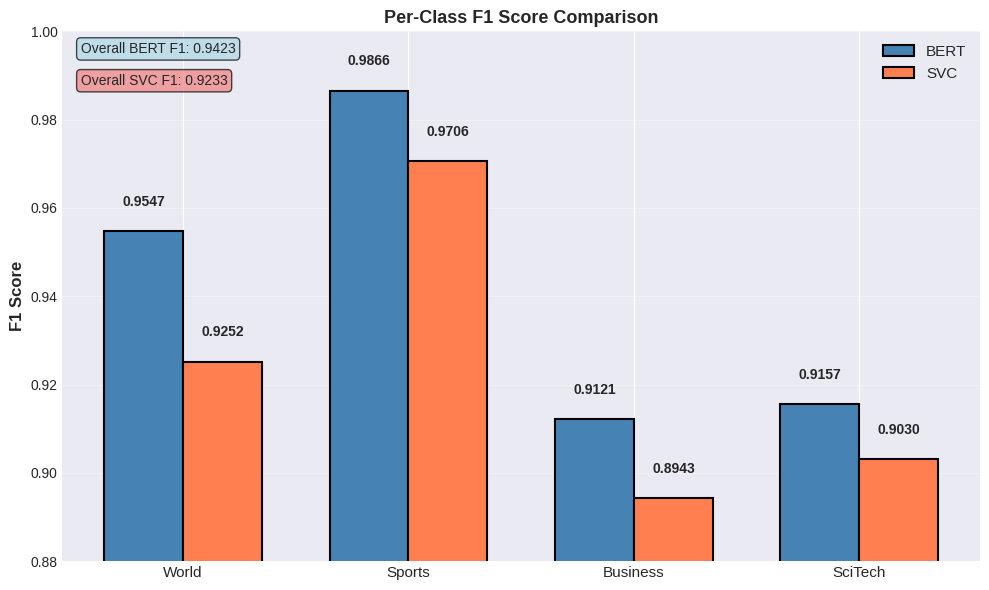

In [5]:
# ============================================================================
# Cell 15.5: Figure 4 - Per-Class F1 Comparison
# ============================================================================

print("\n[9] Creating Figure 4: Per-Class F1 Comparison...")

from sklearn.metrics import classification_report

# BERT per-class F1
bert_preds = test_results['test_predictions']
bert_report = classification_report(y_test, bert_preds, output_dict=True)
bert_f1_scores = [bert_report[str(i)]['f1-score'] for i in range(4)]

# SVC per-class F1
svc_report = classification_report(y_test, svc_preds, output_dict=True)
svc_f1_scores = [svc_report[str(i)]['f1-score'] for i in range(4)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_names))
width = 0.35

bars1 = ax.bar(x - width/2, bert_f1_scores, width, label='BERT', 
               color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, svc_f1_scores, width, label='SVC', 
               color='coral', edgecolor='black', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1 Score Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0.88, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add overall F1 annotations
ax.text(0.02, 0.98, f'Overall BERT F1: {test_results["test_macro_f1"]:.4f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax.text(0.02, 0.92, f'Overall SVC F1: 0.9233',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure4_perclass_f1.png", dpi=300, bbox_inches='tight')
print("✓ Saved: figure4_perclass_f1.png")
plt.show()



[10] Creating Figure 5: Bootstrap Distribution...
✓ Saved: figure5_bootstrap_distribution.png


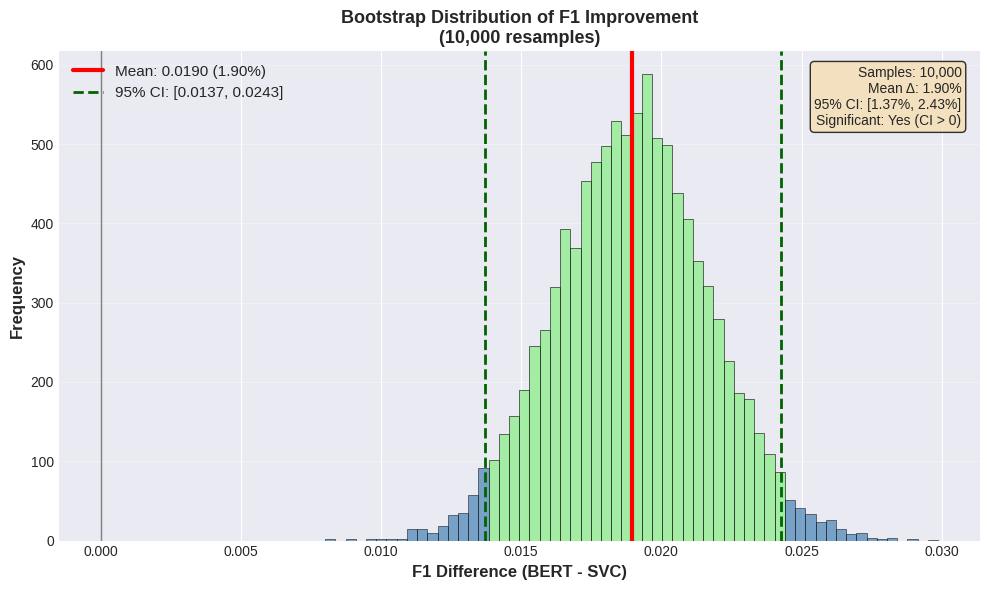

In [7]:
# ============================================================================
# Cell 15.6: Figure 5 - Bootstrap Distribution with CI
# ============================================================================

print("\n[10] Creating Figure 5: Bootstrap Distribution...")

differences = bootstrap_data['differences']
mean_diff = bootstrap_data['mean']
ci_lower = bootstrap_data['ci_lower']
ci_upper = bootstrap_data['ci_upper']

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
n, bins, patches = ax.hist(differences, bins=60, alpha=0.7, color='steelblue', 
                            edgecolor='black', linewidth=0.5)

# Color the CI region
for i, patch in enumerate(patches):
    if ci_lower <= bins[i] <= ci_upper:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.8)

# Add vertical lines
ax.axvline(mean_diff, color='red', linestyle='-', linewidth=3, 
           label=f'Mean: {mean_diff:.4f} ({mean_diff*100:.2f}%)', zorder=5)
ax.axvline(ci_lower, color='darkgreen', linestyle='--', linewidth=2, 
           label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]', zorder=5)
ax.axvline(ci_upper, color='darkgreen', linestyle='--', linewidth=2, zorder=5)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, zorder=5)

ax.set_xlabel('F1 Difference (BERT - SVC)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Bootstrap Distribution of F1 Improvement\n(10,000 resamples)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Add text box with statistics
textstr = f'Samples: 10,000\nMean Δ: {mean_diff*100:.2f}%\n95% CI: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]\nSignificant: Yes (CI > 0)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure5_bootstrap_distribution.png", dpi=300, bbox_inches='tight')
print("✓ Saved: figure5_bootstrap_distribution.png")
plt.show()



In [9]:
# ============================================================================
# Cell 16.1: Load BERT Model and Select Examples for Attention Visualization
# ============================================================================

import torch
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 16: ATTENTION VISUALIZATION")
print("="*80)

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[1] Device: {DEVICE}")

# Load model and tokenizer
print("\n[2] Loading BERT model...")
tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / "step6_distilbert_best")
model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "step6_distilbert_best",
    output_attentions=True  # Important: Enable attention outputs
).to(DEVICE)
model.eval()
print("✓ Model loaded with attention outputs enabled")

# Load error analysis results
print("\n[3] Loading predictions and selecting examples...")
error_df = pd.read_csv(RESULTS_DIR / "step6_error_analysis.csv")
class_names = ['World', 'Sports', 'Business', 'SciTech']

# Select 10 diverse examples:
# - 4 correct predictions (1 per class)
# - 3 BERT correct, SVC wrong
# - 3 BERT wrong (1 both wrong, 2 BERT-only wrong)

examples = []

# 1. One correctly classified example from each class
print("\n  Selecting examples:")
for class_idx in range(4):
    correct_examples = error_df[
        (error_df['true_label'] == class_idx) & 
        (error_df['bert_correct'] == True)
    ]
    if len(correct_examples) > 0:
        example = correct_examples.iloc[0]
        examples.append({
            'text': example['text'],
            'true_label': class_idx,
            'bert_pred': example['bert_pred'],
            'category': f'Correct ({class_names[class_idx]})'
        })
        print(f"  ✓ Correct {class_names[class_idx]} example")

# 2. BERT correct, SVC wrong (3 examples)
bert_wins = error_df[error_df['error_type'] == 'bert_only_correct']
for i in range(min(3, len(bert_wins))):
    example = bert_wins.iloc[i]
    examples.append({
        'text': example['text'],
        'true_label': int(example['true_label']),
        'bert_pred': int(example['bert_pred']),
        'category': 'BERT Correct, SVC Wrong'
    })
print(f"  ✓ {min(3, len(bert_wins))} BERT-wins examples")

# 3. BERT wrong (3 examples: mix of both-wrong and BERT-only-wrong)
bert_errors = error_df[error_df['bert_correct'] == False]
for i in range(min(3, len(bert_errors))):
    example = bert_errors.iloc[i]
    examples.append({
        'text': example['text'],
        'true_label': int(example['true_label']),
        'bert_pred': int(example['bert_pred']),
        'category': 'BERT Wrong'
    })
print(f"  ✓ {min(3, len(bert_errors))} BERT-error examples")

print(f"\n✓ Selected {len(examples)} examples for visualization")


CELL 16: ATTENTION VISUALIZATION

[1] Device: cuda

[2] Loading BERT model...
✓ Model loaded with attention outputs enabled

[3] Loading predictions and selecting examples...

  Selecting examples:
  ✓ Correct World example
  ✓ Correct Sports example
  ✓ Correct Business example
  ✓ Correct SciTech example
  ✓ 3 BERT-wins examples
  ✓ 3 BERT-error examples

✓ Selected 10 examples for visualization


In [10]:
# ============================================================================
# Cell 16.2: Extract Attention Weights from Model
# ============================================================================

print("\n[4] Extracting attention weights...")

attention_data = []

for idx, example in enumerate(examples):
    text = example['text']
    
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=256,
        padding='max_length'
    )
    
    input_ids = inputs['input_ids'].to(DEVICE)
    attention_mask = inputs['attention_mask'].to(DEVICE)
    
    # Get tokens for visualization
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Forward pass with attention
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        attentions = outputs.attentions  # Tuple of (batch, heads, seq_len, seq_len)
    
    # Get prediction
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    
    # Average attention across all heads and layers
    # attentions: tuple of 6 layers, each (1, 12, seq_len, seq_len)
    # We'll use the last layer's attention
    last_layer_attention = attentions[-1]  # Shape: (1, 12, seq_len, seq_len)
    
    # Average across heads: (1, 12, seq_len, seq_len) -> (seq_len, seq_len)
    avg_attention = last_layer_attention[0].mean(dim=0).cpu().numpy()
    
    # Get attention to [CLS] token (first token)
    # This shows which tokens the model focuses on for classification
    cls_attention = avg_attention[0, :]  # Attention from [CLS] to all tokens
    
    # Only keep non-padding tokens
    seq_len = attention_mask.sum().item()
    tokens = tokens[:seq_len]
    cls_attention = cls_attention[:seq_len]
    
    # Store results
    attention_data.append({
        'example_idx': idx,
        'text': text,
        'tokens': tokens,
        'attention': cls_attention,
        'true_label': example['true_label'],
        'pred_label': pred,
        'confidence': probs[pred],
        'category': example['category'],
        'is_correct': pred == example['true_label']
    })
    
    print(f"  [{idx+1}/{len(examples)}] Processed: {example['category']}")

print(f"\n✓ Extracted attention for {len(attention_data)} examples")



[4] Extracting attention weights...
  [1/10] Processed: Correct (World)
  [2/10] Processed: Correct (Sports)
  [3/10] Processed: Correct (Business)
  [4/10] Processed: Correct (SciTech)
  [5/10] Processed: BERT Correct, SVC Wrong
  [6/10] Processed: BERT Correct, SVC Wrong
  [7/10] Processed: BERT Correct, SVC Wrong
  [8/10] Processed: BERT Wrong
  [9/10] Processed: BERT Wrong
  [10/10] Processed: BERT Wrong

✓ Extracted attention for 10 examples


In [11]:
# ============================================================================
# Cell 16.3: Identify Top Attended Tokens
# ============================================================================

print("\n[5] Analyzing top attended tokens...")

for data in attention_data:
    tokens = data['tokens']
    attention = data['attention']
    
    # Remove special tokens for analysis
    content_tokens = []
    content_attention = []
    
    for token, att in zip(tokens, attention):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            content_tokens.append(token)
            content_attention.append(att)
    
    # Get top 5 attended tokens
    if len(content_attention) > 0:
        top_indices = np.argsort(content_attention)[-5:][::-1]
        top_tokens = [content_tokens[i] for i in top_indices]
        top_scores = [content_attention[i] for i in top_indices]
        
        data['top_tokens'] = top_tokens
        data['top_scores'] = top_scores
    else:
        data['top_tokens'] = []
        data['top_scores'] = []

# Print summary
print("\nTop 5 Attended Tokens per Example:")
print("="*80)
for data in attention_data:
    print(f"\nExample {data['example_idx']+1}: {data['category']}")
    print(f"  True: {class_names[data['true_label']]} | "
          f"Pred: {class_names[data['pred_label']]} "
          f"({'✓' if data['is_correct'] else '✗'}) | "
          f"Conf: {data['confidence']:.3f}")
    print(f"  Text: {data['text'][:100]}...")
    print(f"  Top tokens:")
    for token, score in zip(data['top_tokens'], data['top_scores']):
        print(f"    {token:20s} → {score:.4f}")



[5] Analyzing top attended tokens...

Top 5 Attended Tokens per Example:

Example 1: Correct (World)
  True: World | Pred: World (✓) | Conf: 0.999
  Text: Sister of man who died in Vancouver police custody slams chief (Canadian Press) Canadian Press - VAN...
  Top tokens:
    .                    → 0.2338
    sister               → 0.0466
    -                    → 0.0458
    sister               → 0.0448
    press                → 0.0437

Example 2: Correct (Sports)
  True: Sports | Pred: Sports (✓) | Conf: 0.929
  Text: Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in the 400 individual med...
  Top tokens:
    .                    → 0.3119
    first                → 0.1473
    time                 → 0.0573
    for                  → 0.0478
    medley               → 0.0300

Example 3: Correct (Business)
  True: Business | Pred: Business (✓) | Conf: 0.989
  Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they ar


[6] Creating attention heatmaps...


/tmp/ipykernel_6430/907106147.py:51: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_6430/907106147.py:51: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_6430/907106147.py:52: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.savefig(RESULTS_DIR / "step6_attention_heatmaps.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_6430/907106147.py:52: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.savefig(RESULTS_DIR / "step6_attention_heatmaps.png", dpi=300, bbox_inches='tight')


✓ Saved: step6_attention_heatmaps.png


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


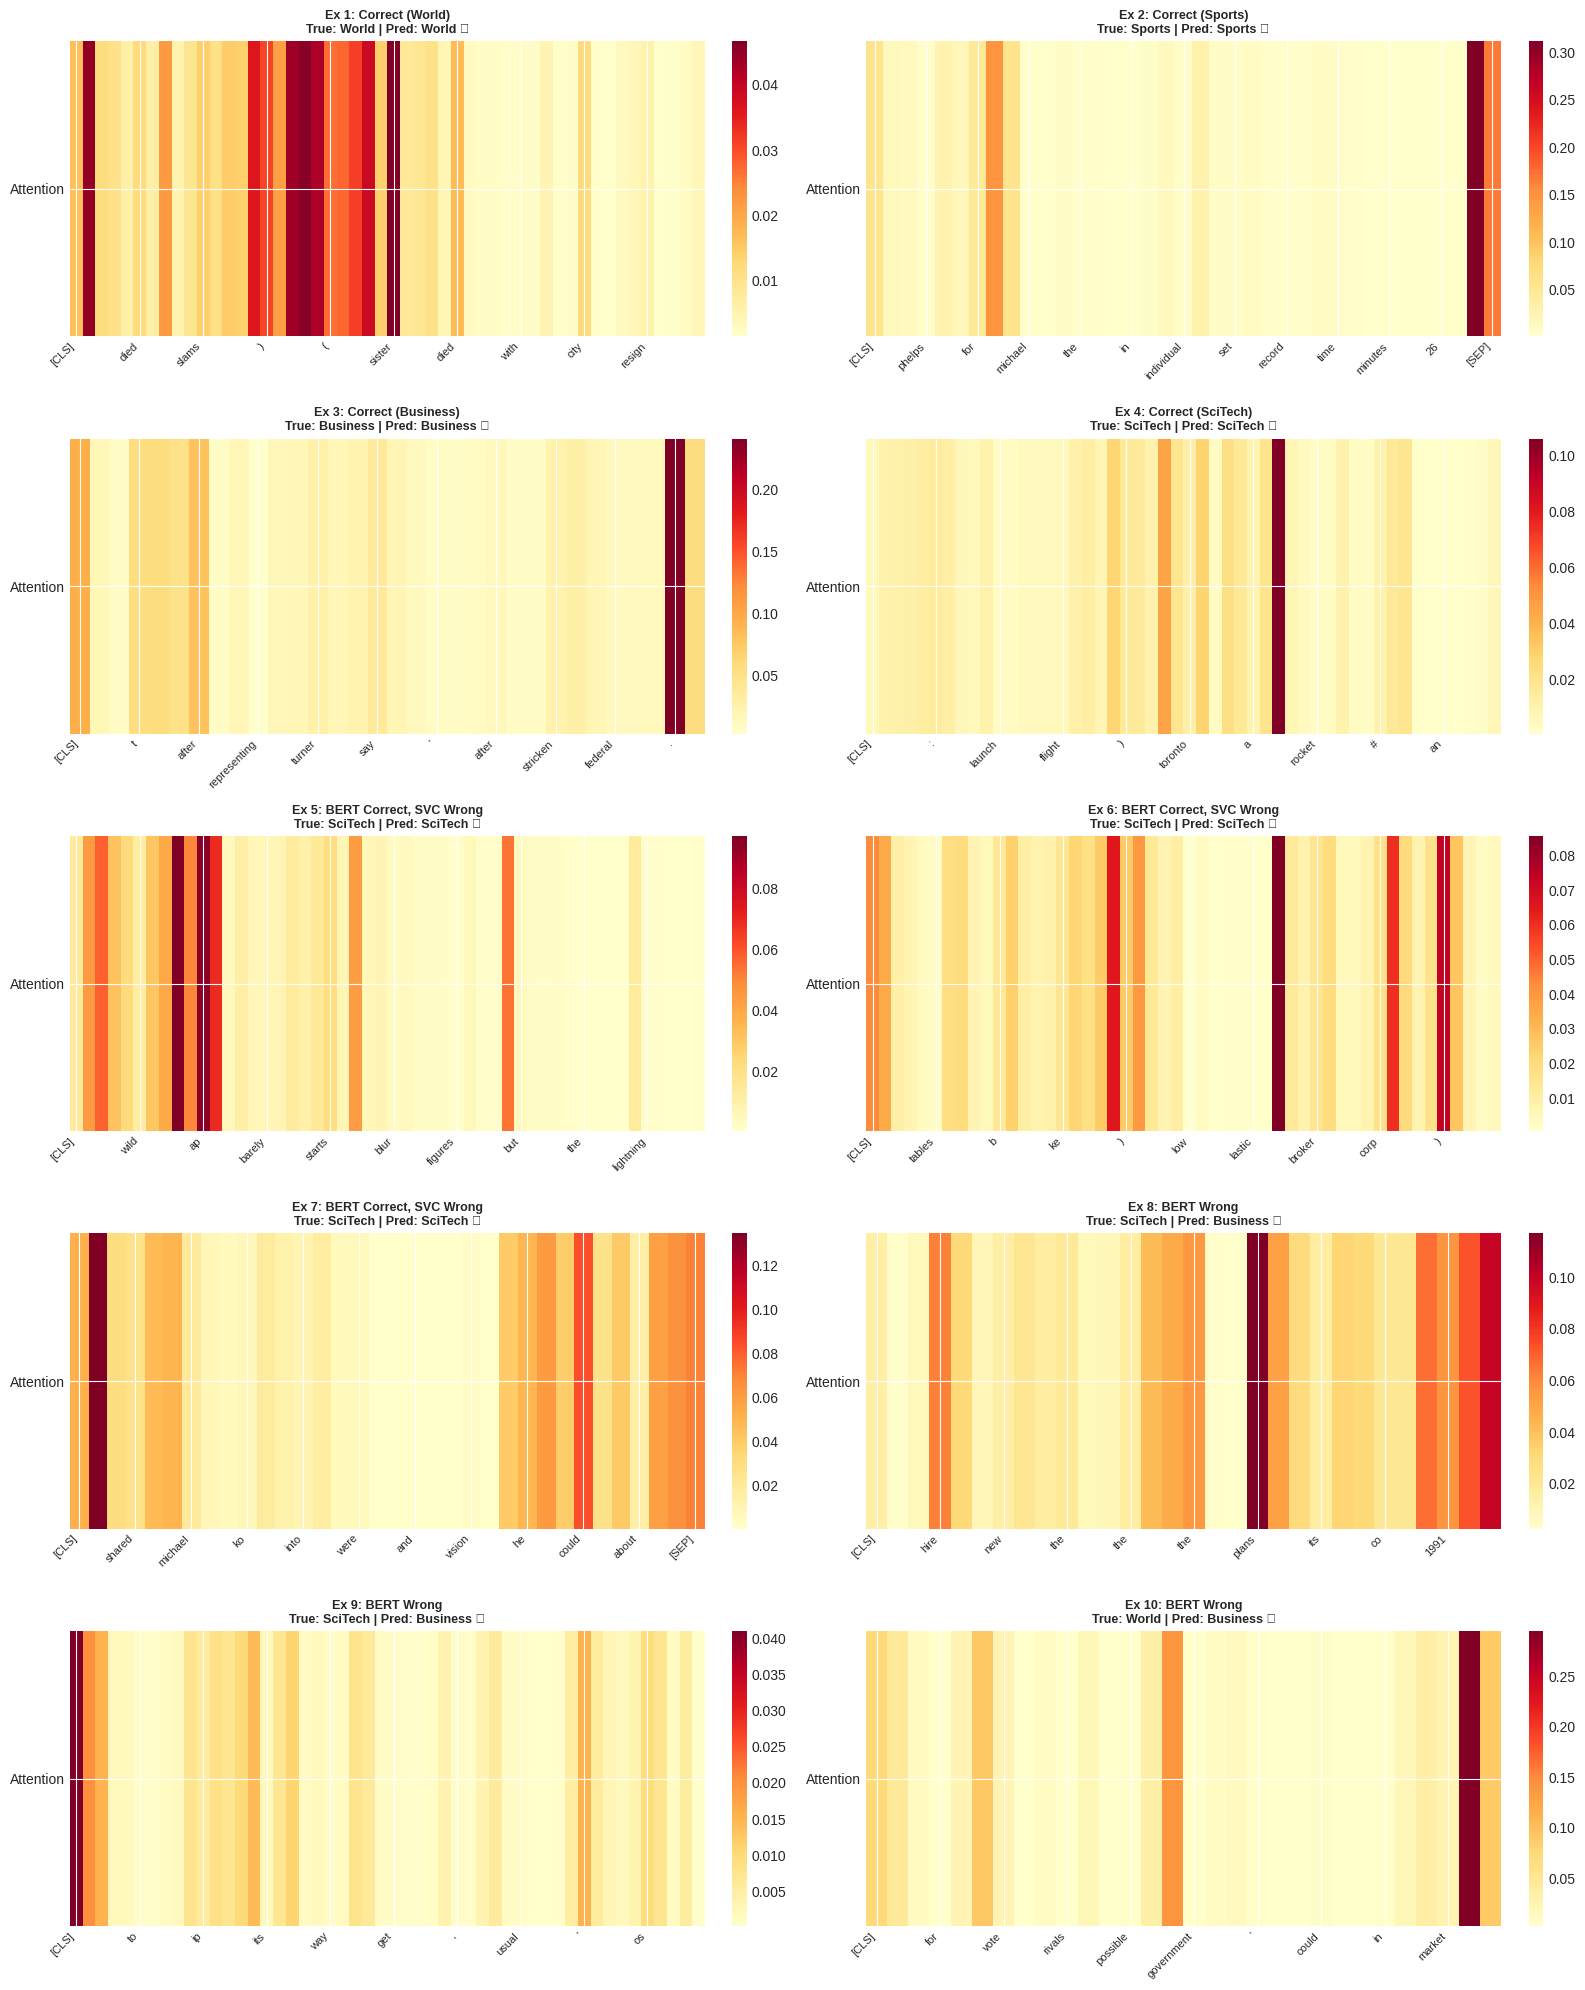

In [12]:
# ============================================================================
# Cell 16.4: Create Attention Heatmap Visualizations
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n[6] Creating attention heatmaps...")

# Create a grid of subplots (5 rows x 2 columns for 10 examples)
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, data in enumerate(attention_data):
    ax = axes[idx]
    
    tokens = data['tokens']
    attention = data['attention']
    
    # Limit to first 50 tokens for visualization
    max_tokens = min(50, len(tokens))
    tokens_vis = tokens[:max_tokens]
    attention_vis = attention[:max_tokens]
    
    # Create heatmap
    attention_matrix = attention_vis.reshape(1, -1)
    
    # Clean tokens (remove ## from subwords)
    clean_tokens = [t.replace('##', '') for t in tokens_vis]
    
    # Plot
    im = ax.imshow(attention_matrix, cmap='YlOrRd', aspect='auto')
    
    # Set ticks
    ax.set_yticks([0])
    ax.set_yticklabels(['Attention'])
    ax.set_xticks(range(0, max_tokens, max(1, max_tokens//10)))
    ax.set_xticklabels([clean_tokens[i] for i in range(0, max_tokens, max(1, max_tokens//10))], 
                       rotation=45, ha='right', fontsize=8)
    
    # Title
    pred_marker = '✓' if data['is_correct'] else '✗'
    title = f"Ex {idx+1}: {data['category']}\n"
    title += f"True: {class_names[data['true_label']]} | "
    title += f"Pred: {class_names[data['pred_label']]} {pred_marker}"
    ax.set_title(title, fontsize=9, fontweight='bold')
    
    # Colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_attention_heatmaps.png", dpi=300, bbox_inches='tight')
print("✓ Saved: step6_attention_heatmaps.png")
plt.show()


In [14]:
# ============================================================================
# Cell 16.5: Create Attention Summary Table
# ============================================================================

print("\n[7] Creating attention summary table...")

# Create summary DataFrame
summary_data = []

for data in attention_data:
    summary_data.append({
        'Example': data['example_idx'] + 1,
        'Category': data['category'],
        'True Label': class_names[data['true_label']],
        'Predicted': class_names[data['pred_label']],
        'Correct': '✓' if data['is_correct'] else '✗',
        'Confidence': f"{data['confidence']:.3f}",
        'Top 1 Token': data['top_tokens'][0] if data['top_tokens'] else '',
        'Top 1 Score': f"{data['top_scores'][0]:.4f}" if data['top_scores'] else '',
        'Text Preview': data['text'][:80] + '...'
    })

summary_df = pd.DataFrame(summary_data)

print("\nAttention Analysis Summary:")
print("="*80)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(RESULTS_DIR / "step6_attention_summary.csv", index=False)
print(f"\n✓ Saved: step6_attention_summary.csv")




[7] Creating attention summary table...

Attention Analysis Summary:
 Example                Category True Label Predicted Correct Confidence Top 1 Token Top 1 Score                                                                        Text Preview
       1         Correct (World)      World     World       ✓      0.999           .      0.2338 Sister of man who died in Vancouver police custody slams chief (Canadian Press) ...
       2        Correct (Sports)     Sports    Sports       ✓      0.929           .      0.3119 Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in th...
       3      Correct (Business)   Business  Business       ✓      0.989           .      0.2415 Fears for T N pension after talks Unions representing workers at Turner   Newall...
       4       Correct (SciTech)    SciTech   SciTech       ✓      0.997           .      0.1865 The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPAC...
       5 BERT Correct, SV

In [16]:
# ============================================================================
# Cell 17.1: Install LIME and Setup
# ============================================================================

# Install LIME if not already installed
# Uncomment the line below if needed:
# !pip install lime

import numpy as np
import pandas as pd
import joblib
import torch
from pathlib import Path
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("="*80)
print("CELL 17: LIME EXPLAINABILITY")
print("="*80)

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
RESULTS_DIR = Path("results")

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[1] Device: {DEVICE}")

# Load model and tokenizer
print("\n[2] Loading BERT model...")
tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / "step6_distilbert_best")
model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "step6_distilbert_best"
).to(DEVICE)
model.eval()
print("✓ Model loaded")

# Class names
class_names = ['World', 'Sports', 'Business', 'SciTech']


CELL 17: LIME EXPLAINABILITY

[1] Device: cuda

[2] Loading BERT model...
✓ Model loaded


In [17]:
# ============================================================================
# Cell 17.2: Create Prediction Wrapper for LIME
# ============================================================================

print("\n[3] Creating BERT prediction wrapper for LIME...")

def bert_predict_proba(texts):
    """
    Wrapper function for BERT that LIME can use.
    Takes a list of text strings and returns probability predictions.
    """
    # Tokenize batch
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        max_length=256,
        padding=True
    )
    
    input_ids = inputs['input_ids'].to(DEVICE)
    attention_mask = inputs['attention_mask'].to(DEVICE)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    
    return probs

# Test the wrapper
test_text = ["This is a test sentence about sports."]
test_probs = bert_predict_proba(test_text)
print(f"✓ Wrapper function working")
print(f"  Test prediction: {class_names[np.argmax(test_probs[0])]} ({test_probs[0].max():.3f})")

# Initialize LIME explainer
print("\n[4] Initializing LIME explainer...")
explainer = LimeTextExplainer(
    class_names=class_names,
    random_state=42
)
print("✓ LIME explainer initialized")



[3] Creating BERT prediction wrapper for LIME...
✓ Wrapper function working
  Test prediction: World (0.517)

[4] Initializing LIME explainer...
✓ LIME explainer initialized


In [18]:
# ============================================================================
# Cell 17.3: Select Examples for LIME Explanation
# ============================================================================

print("\n[5] Selecting examples for LIME explanation...")

# Load error analysis results
error_df = pd.read_csv(RESULTS_DIR / "step6_error_analysis.csv")

# Select 5 diverse examples (fewer than attention, since LIME is slower)
lime_examples = []

# 1. Two correct predictions (different classes)
correct_world = error_df[
    (error_df['true_label'] == 0) & 
    (error_df['bert_correct'] == True)
].iloc[0]

correct_sports = error_df[
    (error_df['true_label'] == 1) & 
    (error_df['bert_correct'] == True)
].iloc[0]

lime_examples.extend([
    {
        'text': correct_world['text'],
        'true_label': 0,
        'category': 'Correct (World)'
    },
    {
        'text': correct_sports['text'],
        'true_label': 1,
        'category': 'Correct (Sports)'
    }
])

# 2. One BERT correct, SVC wrong
bert_wins = error_df[error_df['error_type'] == 'bert_only_correct']
if len(bert_wins) > 0:
    example = bert_wins.iloc[0]
    lime_examples.append({
        'text': example['text'],
        'true_label': int(example['true_label']),
        'category': 'BERT Correct, SVC Wrong'
    })

# 3. Two BERT errors
bert_errors = error_df[error_df['bert_correct'] == False]
for i in range(min(2, len(bert_errors))):
    example = bert_errors.iloc[i]
    lime_examples.append({
        'text': example['text'],
        'true_label': int(example['true_label']),
        'category': 'BERT Error'
    })

print(f"✓ Selected {len(lime_examples)} examples for LIME explanation")
for i, ex in enumerate(lime_examples):
    print(f"  {i+1}. {ex['category']}: {ex['text'][:80]}...")



[5] Selecting examples for LIME explanation...
✓ Selected 5 examples for LIME explanation
  1. Correct (World): Sister of man who died in Vancouver police custody slams chief (Canadian Press) ...
  2. Correct (Sports): Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in th...
  3. BERT Correct, SVC Wrong: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fi...
  4. BERT Error: IBM to hire even more new workers By the end of the year, the computing giant pl...
  5. BERT Error: Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a ...


In [19]:
# ============================================================================
# Cell 17.4: Generate LIME Explanations
# ============================================================================

print("\n[6] Generating LIME explanations (this may take ~1 minute per example)...")

lime_results = []

for idx, example in enumerate(lime_examples):
    print(f"\n  [{idx+1}/{len(lime_examples)}] Explaining: {example['category']}")
    
    text = example['text']
    true_label = example['true_label']
    
    # Get BERT prediction
    bert_prob = bert_predict_proba([text])[0]
    bert_pred = np.argmax(bert_prob)
    
    # Generate LIME explanation
    # num_features: how many words to highlight
    # num_samples: how many perturbed samples to generate (higher = more accurate but slower)
    explanation = explainer.explain_instance(
        text,
        bert_predict_proba,
        num_features=10,  # Top 10 words
        num_samples=1000,  # Reduced from default 5000 for speed
        top_labels=4  # Explain all classes
    )
    
    # Get feature importance for predicted class
    word_importances = explanation.as_list(label=bert_pred)
    
    # Separate positive and negative contributions
    positive_words = [(word, weight) for word, weight in word_importances if weight > 0]
    negative_words = [(word, weight) for word, weight in word_importances if weight < 0]
    
    # Sort by absolute weight
    positive_words = sorted(positive_words, key=lambda x: x[1], reverse=True)
    negative_words = sorted(negative_words, key=lambda x: x[1])
    
    lime_results.append({
        'example_idx': idx,
        'text': text,
        'true_label': true_label,
        'pred_label': bert_pred,
        'confidence': bert_prob[bert_pred],
        'category': example['category'],
        'is_correct': bert_pred == true_label,
        'positive_words': positive_words,
        'negative_words': negative_words,
        'explanation_object': explanation
    })
    
    print(f"    Pred: {class_names[bert_pred]} ({bert_prob[bert_pred]:.3f})")
    print(f"    Top positive: {positive_words[:3] if positive_words else 'None'}")
    print(f"    Top negative: {negative_words[:3] if negative_words else 'None'}")

print(f"\n✓ Generated {len(lime_results)} LIME explanations")



[6] Generating LIME explanations (this may take ~1 minute per example)...

  [1/5] Explaining: Correct (World)
    Pred: World (0.999)
    Top positive: [('Press', 0.02725699274171107), ('Canadian', 0.02723401575303638), ('CP', 0.02066024979738509)]
    Top negative: [('slams', -0.018342561326569747)]

  [2/5] Explaining: Correct (Sports)
    Pred: Sports (0.929)
    Top positive: [('26', 0.3218043500817864), ('seconds', 0.17174596122468816), ('Giddy', 0.13139682968691113)]
    Top negative: [('First', -0.08551265868629031), ('minutes', -0.0745414631518721), ('Touches', -0.06267367779128553)]

  [3/5] Explaining: BERT Correct, SVC Wrong
    Pred: SciTech (0.992)
    Top positive: [('Prediction', 0.28286334772499266), ('Wildfires', 0.2816118175689895), ('charts', 0.09602048078072412)]
    Top negative: [('Unit', -0.06352995526274877), ('colorful', -0.05959933937850144), ('Fitzpatrick', -0.057946125834438686)]

  [4/5] Explaining: BERT Error
    Pred: Business (0.585)
    Top positive: 


[7] Creating LIME explanation visualizations...


/tmp/ipykernel_6430/2699484163.py:55: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_6430/2699484163.py:55: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_6430/2699484163.py:56: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.savefig(RESULTS_DIR / "step6_lime_explanations.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_6430/2699484163.py:56: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.savefig(RESULTS_DIR / "step6_lime_explanations.png", dpi=300, bbox_inches='tight')


✓ Saved: step6_lime_explanations.png


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


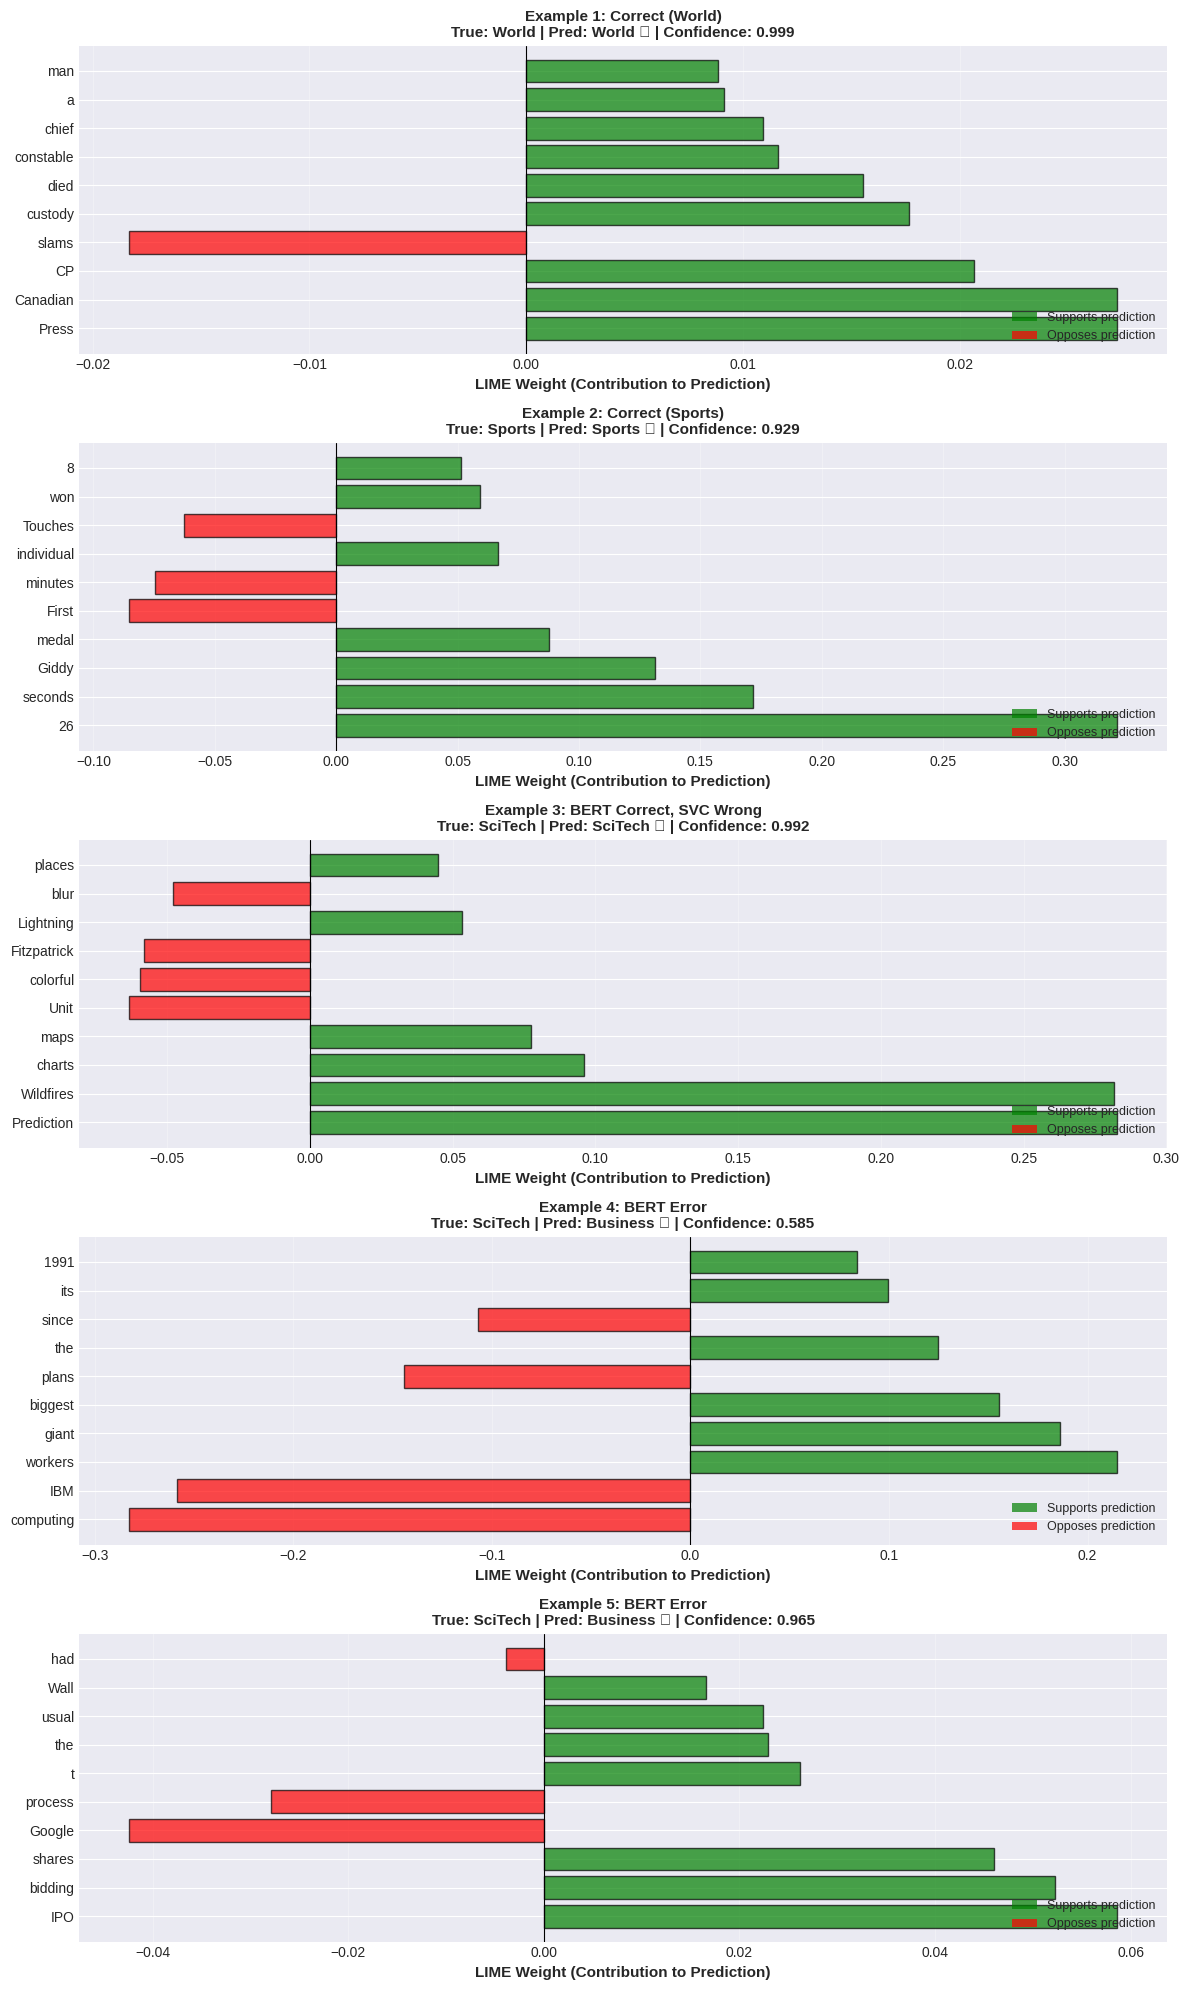

In [20]:
# ============================================================================
# Cell 17.5: Visualize LIME Explanations
# ============================================================================

import matplotlib.pyplot as plt

print("\n[7] Creating LIME explanation visualizations...")

# Create subplots for each example
fig, axes = plt.subplots(len(lime_results), 1, figsize=(12, 4*len(lime_results)))

if len(lime_results) == 1:
    axes = [axes]

for idx, (ax, result) in enumerate(zip(axes, lime_results)):
    # Get top 10 words (positive and negative combined)
    all_words = result['positive_words'] + result['negative_words']
    all_words = sorted(all_words, key=lambda x: abs(x[1]), reverse=True)[:10]
    
    if len(all_words) == 0:
        continue
    
    # Extract words and weights
    words = [w[0] for w in all_words]
    weights = [w[1] for w in all_words]
    
    # Create horizontal bar chart
    colors = ['green' if w > 0 else 'red' for w in weights]
    y_pos = np.arange(len(words))
    
    ax.barh(y_pos, weights, color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words, fontsize=10)
    ax.set_xlabel('LIME Weight (Contribution to Prediction)', fontsize=11, fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.8)
    
    # Title
    pred_marker = '✓' if result['is_correct'] else '✗'
    title = f"Example {idx+1}: {result['category']}\n"
    title += f"True: {class_names[result['true_label']]} | "
    title += f"Pred: {class_names[result['pred_label']]} {pred_marker} | "
    title += f"Confidence: {result['confidence']:.3f}"
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Supports prediction'),
        Patch(facecolor='red', alpha=0.7, label='Opposes prediction')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_lime_explanations.png", dpi=300, bbox_inches='tight')
print("✓ Saved: step6_lime_explanations.png")
plt.show()


In [21]:
# ============================================================================
# Cell 17.6: LIME Summary and Comparison with Attention
# ============================================================================

print("\n[8] Creating LIME summary...")

# Create summary table
summary_data = []

for result in lime_results:
    # Top 3 positive and negative words
    top_positive = result['positive_words'][:3]
    top_negative = result['negative_words'][:3]
    
    pos_str = ', '.join([f"{w} ({v:.3f})" for w, v in top_positive])
    neg_str = ', '.join([f"{w} ({v:.3f})" for w, v in top_negative])
    
    summary_data.append({
        'Example': result['example_idx'] + 1,
        'Category': result['category'],
        'True Label': class_names[result['true_label']],
        'Predicted': class_names[result['pred_label']],
        'Correct': '✓' if result['is_correct'] else '✗',
        'Confidence': f"{result['confidence']:.3f}",
        'Top Positive Words': pos_str if pos_str else 'None',
        'Top Negative Words': neg_str if neg_str else 'None',
        'Text Preview': result['text'][:100] + '...'
    })

summary_df = pd.DataFrame(summary_data)

print("\nLIME Explanation Summary:")
print("="*80)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(RESULTS_DIR / "step6_lime_summary.csv", index=False)
print(f"\n✓ Saved: step6_lime_summary.csv")



[8] Creating LIME summary...

LIME Explanation Summary:
 Example                Category True Label Predicted Correct Confidence                                    Top Positive Words                                     Top Negative Words                                                                                            Text Preview
       1         Correct (World)      World     World       ✓      0.999           Press (0.027), Canadian (0.027), CP (0.021)                                         slams (-0.018) Sister of man who died in Vancouver police custody slams chief (Canadian Press) Canadian Press - VAN...
       2        Correct (Sports)     Sports    Sports       ✓      0.929            26 (0.322), seconds (0.172), Giddy (0.131)     First (-0.086), minutes (-0.075), Touches (-0.063) Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in the 400 individual med...
       3 BERT Correct, SVC Wrong    SciTech   SciTech       ✓      0.992 Prediction (

In [22]:
# ============================================================================
# Cell 14.1: Data Efficiency - Prepare 50% Training Subset
# ============================================================================

import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.model_selection import train_test_split

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 14: DATA EFFICIENCY ABLATION (50% Training Data)")
print("="*80)

# Set device and random seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

print(f"\n[1] Device: {DEVICE}")

# Load full training data
print("\n[2] Loading full training data...")
train_df = pd.read_csv(DATA_DIR / "train.csv")
y_train = train_df['label'].values

print(f"✓ Full training set: {len(train_df)} samples")
print(f"  Class distribution: {np.bincount(y_train)}")

# Create stratified 50% subset
print("\n[3] Creating stratified 50% subset...")
train_50_df, _ = train_test_split(
    train_df,
    train_size=0.5,
    stratify=y_train,
    random_state=RANDOM_STATE
)

y_train_50 = train_50_df['label'].values

print(f"✓ 50% training set: {len(train_50_df)} samples")
print(f"  Class distribution: {np.bincount(y_train_50)}")

# Verify balanced split
for class_idx in range(4):
    orig_count = np.sum(y_train == class_idx)
    subset_count = np.sum(y_train_50 == class_idx)
    print(f"  Class {class_idx}: {subset_count}/{orig_count} ({subset_count/orig_count*100:.1f}%)")


CELL 14: DATA EFFICIENCY ABLATION (50% Training Data)

[1] Device: cuda

[2] Loading full training data...
✓ Full training set: 102000 samples
  Class distribution: [25500 25500 25500 25500]

[3] Creating stratified 50% subset...
✓ 50% training set: 51000 samples
  Class distribution: [12750 12750 12750 12750]
  Class 0: 12750/25500 (50.0%)
  Class 1: 12750/25500 (50.0%)
  Class 2: 12750/25500 (50.0%)
  Class 3: 12750/25500 (50.0%)


In [23]:
# ============================================================================
# Cell 14.2: Setup Tokenization and DataLoaders
# ============================================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

print("\n[4] Tokenizing 50% subset...")

# Load tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 256

# Tokenize 50% subset
train_50_encodings = tokenizer(
    train_50_df['text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

print(f"✓ Tokenized {len(train_50_df)} samples")

# Load validation data for evaluation
print("\n[5] Loading validation data...")
val_df = pd.read_csv(DATA_DIR / "val.csv")
y_val = val_df['label'].values

val_encodings = tokenizer(
    val_df['text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

print(f"✓ Validation set: {len(val_df)} samples")

# Create datasets
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

train_50_dataset = NewsDataset(train_50_encodings, y_train_50)
val_dataset = NewsDataset(val_encodings, y_val)

# Use same batch size as original training
BATCH_SIZE = 64  # From your best hyperparameters

train_50_loader = DataLoader(train_50_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Created DataLoaders:")
print(f"  Train (50%): {len(train_50_loader)} batches")
print(f"  Validation: {len(val_loader)} batches")



[4] Tokenizing 50% subset...
✓ Tokenized 51000 samples

[5] Loading validation data...
✓ Validation set: 18000 samples

✓ Created DataLoaders:
  Train (50%): 797 batches
  Validation: 282 batches


In [24]:
# ============================================================================
# Cell 14.3: Train BERT on 50% Data with Best Hyperparameters
# ============================================================================

import joblib
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
import time

print("\n[6] Setting up training with best hyperparameters...")

# Load best hyperparameters from full training
best_params = joblib.load(RESULTS_DIR / "step6_best_params.pkl")
LEARNING_RATE = best_params['learning_rate']
WEIGHT_DECAY = best_params['weight_decay']
WARMUP_RATIO = best_params['warmup_ratio']

print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Warmup ratio: {WARMUP_RATIO}")

# Create fresh model
print("\n[7] Initializing fresh BERT model...")
model_50 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    problem_type="single_label_classification"
).to(DEVICE)

# Optimizer and scheduler
optimizer = AdamW(model_50.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

num_training_steps = len(train_50_loader) * 4  # 4 epochs
num_warmup_steps = int(num_training_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

scaler = GradScaler(device='cuda')

print(f"✓ Training setup complete")
print(f"  Total steps: {num_training_steps}")
print(f"  Warmup steps: {num_warmup_steps}")

# Training and evaluation functions
def train_epoch(model, train_loader, optimizer, scheduler, scaler, device, epoch, num_epochs):
    model.train()
    total_loss = 0.0
    
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} | Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")
    
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, f1, acc

print("\n[8] Training BERT on 50% data (4 epochs)...")
print("="*80)

best_f1_50 = 0.0
training_history_50 = []

start_time = time.time()

for epoch in range(4):
    print(f"\nEpoch {epoch+1}/4")
    print("-" * 80)
    
    train_loss = train_epoch(model_50, train_50_loader, optimizer, scheduler, scaler, DEVICE, epoch, 4)
    val_loss, val_f1, val_acc = evaluate(model_50, val_loader, DEVICE)
    
    training_history_50.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_f1': val_f1,
        'val_acc': val_acc
    })
    
    print(f"\n  Epoch {epoch+1} Summary:")
    print(f"    Train Loss: {train_loss:.4f}")
    print(f"    Val Loss: {val_loss:.4f}")
    print(f"    Val F1: {val_f1:.4f}")
    print(f"    Val Acc: {val_acc:.4f}")
    
    if val_f1 > best_f1_50:
        best_f1_50 = val_f1
        print(f"    ✓ New best F1: {best_f1_50:.4f}")

training_time = time.time() - start_time

print("\n" + "="*80)
print(f"✓ Training complete!")
print(f"  Best validation F1 (50% data): {best_f1_50:.4f}")
print(f"  Training time: {training_time/60:.2f} minutes")



[6] Setting up training with best hyperparameters...
  Learning rate: 2.8219443464878743e-05
  Weight decay: 0.021537846530908268
  Warmup ratio: 0.04481839946966742

[7] Initializing fresh BERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Training setup complete
  Total steps: 3188
  Warmup steps: 142

[8] Training BERT on 50% data (4 epochs)...

Epoch 1/4
--------------------------------------------------------------------------------
  Epoch 1/4 | Batch 100/797 | Loss: 0.3055
  Epoch 1/4 | Batch 200/797 | Loss: 0.1970
  Epoch 1/4 | Batch 300/797 | Loss: 0.2290
  Epoch 1/4 | Batch 400/797 | Loss: 0.1786
  Epoch 1/4 | Batch 500/797 | Loss: 0.3186
  Epoch 1/4 | Batch 600/797 | Loss: 0.2475
  Epoch 1/4 | Batch 700/797 | Loss: 0.4037

  Epoch 1 Summary:
    Train Loss: 0.3445
    Val Loss: 0.2048
    Val F1: 0.9299
    Val Acc: 0.9296
    ✓ New best F1: 0.9299

Epoch 2/4
--------------------------------------------------------------------------------
  Epoch 2/4 | Batch 100/797 | Loss: 0.1580
  Epoch 2/4 | Batch 200/797 | Loss: 0.2904
  Epoch 2/4 | Batch 300/797 | Loss: 0.0748
  Epoch 2/4 | Batch 400/797 | Loss: 0.2461
  Epoch 2/4 | Batch 500/797 | Loss: 0.2545
  Epoch 2/4 | Batch 600/797 | Loss: 0.3267
  Epoch 2/4 | Bat

In [25]:
# ============================================================================
# Cell 14.4: Compare 50% vs 100% Data Performance
# ============================================================================

import joblib
import matplotlib.pyplot as plt

print("\n[9] Comparing data efficiency...")

# Load 100% results
full_training_history = pd.read_csv(RESULTS_DIR / "step6_training_history.csv")
best_f1_100 = full_training_history['val_f1'].max()

print(f"\nData Efficiency Comparison:")
print(f"  50% data:  {best_f1_50:.4f} ({len(train_50_df):,} samples)")
print(f"  100% data: {best_f1_100:.4f} ({len(train_df):,} samples)")
print(f"  Performance gap: {(best_f1_100 - best_f1_50)*100:.2f}%")
print(f"  Data efficiency: {best_f1_50/best_f1_100*100:.2f}% of full performance with 50% data")

# Save results
data_efficiency_results = {
    'training_data_percent': [50, 100],
    'training_samples': [len(train_50_df), len(train_df)],
    'best_val_f1': [best_f1_50, best_f1_100],
    'training_history_50': training_history_50,
    'training_history_100': full_training_history.to_dict('records')
}

joblib.dump(data_efficiency_results, RESULTS_DIR / "step6_data_efficiency.pkl")
print(f"\n✓ Saved: step6_data_efficiency.pkl")



[9] Comparing data efficiency...

Data Efficiency Comparison:
  50% data:  0.9404 (51,000 samples)
  100% data: 0.9471 (102,000 samples)
  Performance gap: 0.67%
  Data efficiency: 99.30% of full performance with 50% data

✓ Saved: step6_data_efficiency.pkl



[10] Creating data efficiency visualization...
✓ Saved: step6_data_efficiency_curve.png


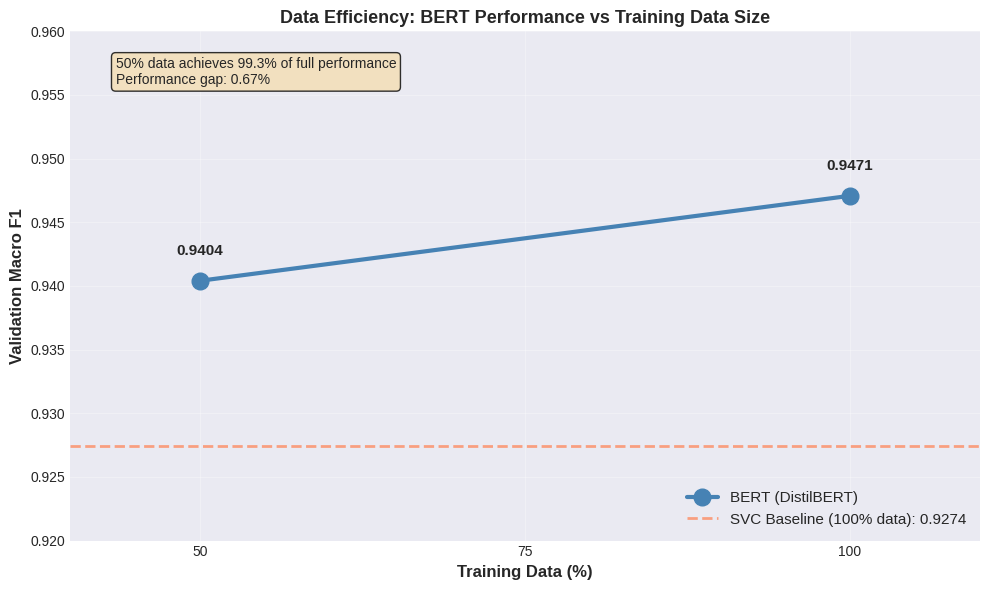


✓ CELL 14 COMPLETE: Data Efficiency Ablation

Key Findings:
1. 50% data: 0.9404 (51,000 samples)
2. 100% data: 0.9471 (102,000 samples)
3. Performance gap: 0.67%
4. BERT needs substantial data to reach peak performance


In [26]:
# ============================================================================
# Cell 14.5: Visualize Data Efficiency Curve
# ============================================================================

print("\n[10] Creating data efficiency visualization...")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data efficiency curve
data_sizes = [50, 100]
f1_scores = [best_f1_50, best_f1_100]

ax.plot(data_sizes, f1_scores, 'o-', linewidth=3, markersize=12, 
        color='steelblue', label='BERT (DistilBERT)')

# Add value labels
for size, score in zip(data_sizes, f1_scores):
    ax.text(size, score + 0.002, f'{score:.4f}', 
            ha='center', fontsize=11, fontweight='bold')

# Add baseline reference (SVC at 100%)
svc_f1 = 0.9274
ax.axhline(svc_f1, color='coral', linestyle='--', linewidth=2, 
           label=f'SVC Baseline (100% data): {svc_f1:.4f}', alpha=0.7)

ax.set_xlabel('Training Data (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Macro F1', fontsize=12, fontweight='bold')
ax.set_title('Data Efficiency: BERT Performance vs Training Data Size', 
             fontsize=13, fontweight='bold')
ax.set_xlim([40, 110])
ax.set_ylim([0.92, 0.96])
ax.set_xticks([50, 75, 100])
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)

# Add annotation
efficiency_pct = (best_f1_50 / best_f1_100) * 100
ax.text(0.05, 0.95, 
        f'50% data achieves {efficiency_pct:.1f}% of full performance\n'
        f'Performance gap: {(best_f1_100 - best_f1_50)*100:.2f}%',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_data_efficiency_curve.png", dpi=300, bbox_inches='tight')
print("✓ Saved: step6_data_efficiency_curve.png")
plt.show()

print("\n" + "="*80)
print("✓ CELL 14 COMPLETE: Data Efficiency Ablation")
print("="*80)
print(f"\nKey Findings:")
print(f"1. 50% data: {best_f1_50:.4f} ({len(train_50_df):,} samples)")
print(f"2. 100% data: {best_f1_100:.4f} ({len(train_df):,} samples)")
print(f"3. Performance gap: {(best_f1_100 - best_f1_50)*100:.2f}%")
print(f"4. BERT needs substantial data to reach peak performance")



[11] Updating ablation studies figure with data efficiency...
✓ Saved: figure3_ablation_studies_complete.png (updated)


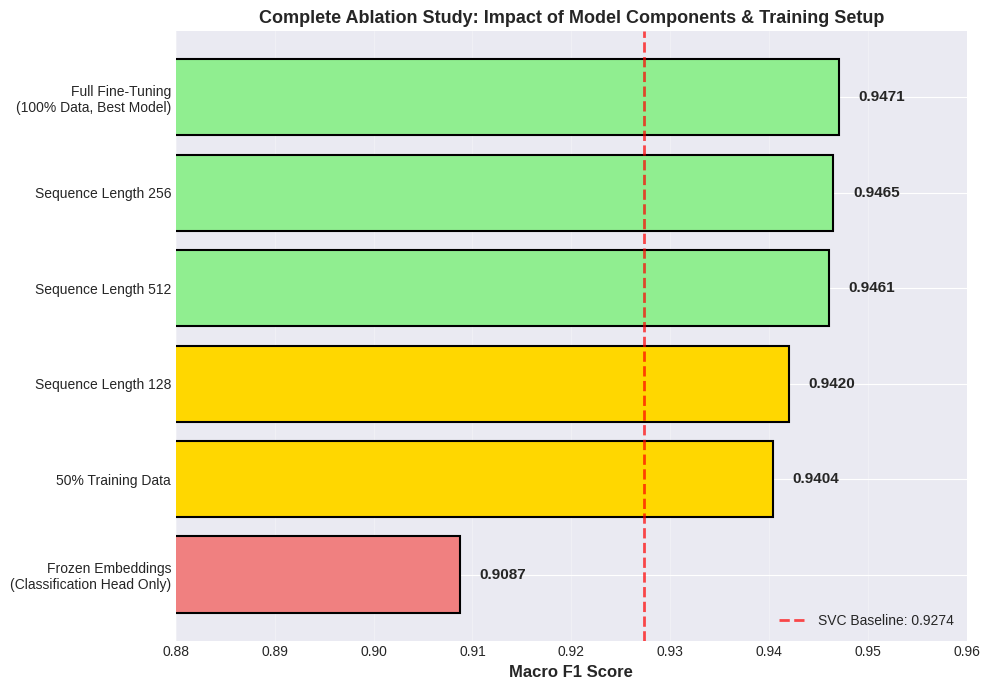


✓ Updated Figure 3 with data efficiency results!


In [27]:
# ============================================================================
# Cell 14.6: Update Figure 3 with Data Efficiency Results
# ============================================================================

print("\n[11] Updating ablation studies figure with data efficiency...")

import joblib

# Load all ablation results
ablation_frozen = joblib.load(RESULTS_DIR / "step6_ablation_frozen_vs_tuned.pkl")
ablation_length = joblib.load(RESULTS_DIR / "step6_ablation_sequence_length.pkl")

# Compile ALL ablation results
ablation_results = {
    'Frozen Embeddings\n(Classification Head Only)': ablation_frozen['frozen_f1'],
    'Sequence Length 128': ablation_length[128],
    'Sequence Length 256': ablation_length[256],
    'Sequence Length 512': ablation_length[512],
    '50% Training Data': best_f1_50,
    'Full Fine-Tuning\n(100% Data, Best Model)': ablation_frozen['full_tuning_f1']
}

# Sort by F1 score
sorted_results = dict(sorted(ablation_results.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(10, 7))

labels = list(sorted_results.keys())
values = list(sorted_results.values())
colors = ['lightcoral' if v < 0.93 else 'gold' if v < 0.945 else 'lightgreen' for v in values]

bars = ax.barh(labels, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(val + 0.002, i, f'{val:.4f}', va='center', fontsize=11, fontweight='bold')

# Add baseline line (SVC)
svc_f1 = 0.9274
ax.axvline(svc_f1, color='red', linestyle='--', linewidth=2, 
           label=f'SVC Baseline: {svc_f1:.4f}', alpha=0.7)

ax.set_xlabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Complete Ablation Study: Impact of Model Components & Training Setup', 
             fontsize=13, fontweight='bold')
ax.set_xlim([0.88, 0.96])
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figure3_ablation_studies_complete.png", dpi=300, bbox_inches='tight')
print("✓ Saved: figure3_ablation_studies_complete.png (updated)")
plt.show()

print("\n✓ Updated Figure 3 with data efficiency results!")


In [28]:
# ============================================================================
# Cell 19.1: Load BERT and Classical Models for Ensemble
# ============================================================================

import numpy as np
import pandas as pd
import joblib
import torch
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report
import scipy.sparse as sp_sparse

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
FEATURES_DIR = Path("features")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 19: HYBRID ENSEMBLE (BERT + Classical Models)")
print("="*80)

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[1] Device: {DEVICE}")

print("\n[2] Loading classical models...")
# Load classical models
svc_model = joblib.load(MODELS_DIR / "step5_tuned_SVC.pkl")
sgd_model = joblib.load(MODELS_DIR / "step5_tuned_SGD.pkl")
nb_model = joblib.load(MODELS_DIR / "step5_tuned_NB.pkl")
lgbm_model = joblib.load(MODELS_DIR / "step5_tuned_LGBM.pkl")

print("✓ Loaded 4 classical models: SVC, SGD, NB, LGBM")

print("\n[3] Loading BERT model...")
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / "step6_distilbert_best")
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "step6_distilbert_best"
).to(DEVICE)
bert_model.eval()
print("✓ Loaded BERT model")


CELL 19: HYBRID ENSEMBLE (BERT + Classical Models)

[1] Device: cuda

[2] Loading classical models...
✓ Loaded 4 classical models: SVC, SGD, NB, LGBM

[3] Loading BERT model...
✓ Loaded BERT model


In [29]:
# ============================================================================
# Cell 19.2: Generate BERT Probability Predictions on Validation Set
# ============================================================================

from torch.utils.data import Dataset, DataLoader

print("\n[4] Loading validation data...")
val_df = pd.read_csv(DATA_DIR / "val.csv")
y_val = val_df['label'].values
print(f"✓ Validation samples: {len(val_df)}")

print("\n[5] Tokenizing validation data...")
val_encodings = tokenizer(
    val_df['text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

# Create dataset
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

val_dataset = NewsDataset(val_encodings, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("\n[6] Generating BERT probability predictions...")
bert_probs_val = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        bert_probs_val.append(probs)

bert_probs_val = np.vstack(bert_probs_val)
bert_preds_val = np.argmax(bert_probs_val, axis=1)
bert_f1_val = f1_score(y_val, bert_preds_val, average='macro')

print(f"✓ BERT validation F1: {bert_f1_val:.4f}")
print(f"  Predictions shape: {bert_probs_val.shape}")



[4] Loading validation data...
✓ Validation samples: 18000

[5] Tokenizing validation data...

[6] Generating BERT probability predictions...
✓ BERT validation F1: 0.9471
  Predictions shape: (18000, 4)


In [31]:
# ============================================================================
# Cell 19.3: Generate Classical Model Predictions on Validation Set (FIXED)
# ============================================================================

print("\n[7] Loading validation features...")
X_val_hybrid = sp_sparse.load_npz(FEATURES_DIR / "X_val_hybrid.npz")
print(f"✓ Features shape: {X_val_hybrid.shape}")

print("\n[8] Generating classical model predictions...")

# SVC predictions - use predict_proba since it's calibrated
svc_probs = svc_model.predict_proba(X_val_hybrid)
svc_preds = np.argmax(svc_probs, axis=1)
svc_f1 = f1_score(y_val, svc_preds, average='macro')
print(f"  SVC F1: {svc_f1:.4f}")

# SGD predictions (probabilities)
sgd_probs = sgd_model.predict_proba(X_val_hybrid)
sgd_preds = np.argmax(sgd_probs, axis=1)
sgd_f1 = f1_score(y_val, sgd_preds, average='macro')
print(f"  SGD F1: {sgd_f1:.4f}")

# NB predictions (probabilities)
nb_probs = nb_model.predict_proba(X_val_hybrid)
nb_preds = np.argmax(nb_probs, axis=1)
nb_f1 = f1_score(y_val, nb_preds, average='macro')
print(f"  NB F1: {nb_f1:.4f}")

# LGBM predictions (requires feature selection)
print("\n[9] Generating LGBM predictions (with feature selection)...")
selector = joblib.load(MODELS_DIR / "step5_chi2_selector.pkl")
X_val_selected = selector.transform(X_val_hybrid)
lgbm_probs = lgbm_model.predict_proba(X_val_selected)
lgbm_preds = np.argmax(lgbm_probs, axis=1)
lgbm_f1 = f1_score(y_val, lgbm_preds, average='macro')
print(f"  LGBM F1: {lgbm_f1:.4f}")

print("\n✓ All base model predictions generated")



[7] Loading validation features...
✓ Features shape: (18000, 100000)

[8] Generating classical model predictions...
  SVC F1: 0.9274
  SGD F1: 0.9268
  NB F1: 0.9065

[9] Generating LGBM predictions (with feature selection)...
  LGBM F1: 0.9120

✓ All base model predictions generated


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [32]:
# ============================================================================
# Cell 19.4: Stack Predictions and Train Meta-Learner (FIXED)
# ============================================================================

print("\n[10] Creating meta-features...")

# Stack all probability predictions
# All models now output probabilities (4 probs each)
# BERT: 4 probs, SVC: 4 probs, SGD: 4 probs, NB: 4 probs, LGBM: 4 probs
# Total: 20 features

X_meta_val = np.hstack([
    bert_probs_val,      # 4 features (BERT probabilities)
    svc_probs,           # 4 features (SVC probabilities)
    sgd_probs,           # 4 features
    nb_probs,            # 4 features
    lgbm_probs           # 4 features
])

print(f"✓ Meta-features shape: {X_meta_val.shape}")
print(f"  Features per model: BERT(4), SVC(4), SGD(4), NB(4), LGBM(4) = 20 total")

print("\n[11] Training meta-learner (Logistic Regression)...")

# Train meta-learner
meta_learner = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

meta_learner.fit(X_meta_val, y_val)

# Predict with ensemble
ensemble_preds_val = meta_learner.predict(X_meta_val)
ensemble_probs_val = meta_learner.predict_proba(X_meta_val)
ensemble_f1_val = f1_score(y_val, ensemble_preds_val, average='macro')
ensemble_acc_val = accuracy_score(y_val, ensemble_preds_val)

print(f"\n✓ Hybrid Ensemble Validation F1: {ensemble_f1_val:.4f}")
print(f"  Validation Accuracy: {ensemble_acc_val:.4f}")

# Save meta-learner (no need for scaler anymore)
joblib.dump(meta_learner, MODELS_DIR / "step6_hybrid_meta_learner.pkl")
print(f"\n✓ Saved: step6_hybrid_meta_learner.pkl")



[10] Creating meta-features...
✓ Meta-features shape: (18000, 20)
  Features per model: BERT(4), SVC(4), SGD(4), NB(4), LGBM(4) = 20 total

[11] Training meta-learner (Logistic Regression)...

✓ Hybrid Ensemble Validation F1: 0.9501
  Validation Accuracy: 0.9501

✓ Saved: step6_hybrid_meta_learner.pkl



[12] Analyzing meta-learner weights...

Model Contribution to Ensemble (%):
  BERT  : 48.89%
  SVC   : 15.83%
  SGD   : 13.56%
  NB    : 13.06%
  LGBM  :  8.66%

✓ Saved: step6_hybrid_ensemble_weights.png


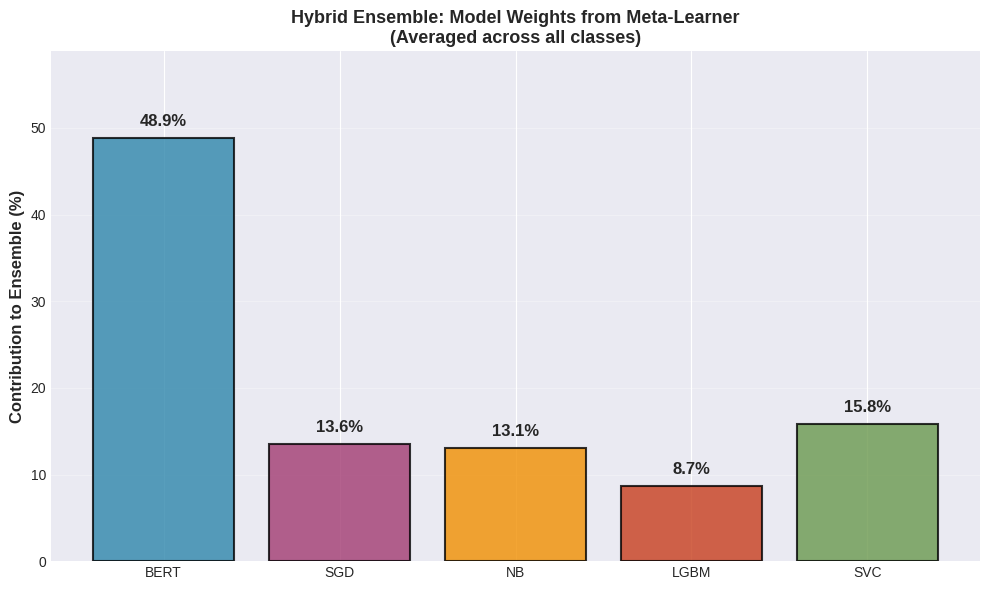

In [33]:
# ============================================================================
# Cell 19.5: Analyze Meta-Learner Weights
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n[12] Analyzing meta-learner weights...")

# Get feature importance from logistic regression coefficients
# For multi-class, coefficients are shape (n_classes, n_features)
# We'll average across classes to get overall importance
coef_matrix = meta_learner.coef_  # Shape: (4, 20)
feature_importance = np.abs(coef_matrix).mean(axis=0)

# Create feature names
feature_names = []
for model, count in [('BERT', 4), ('SGD', 4), ('NB', 4), ('LGBM', 4), ('SVC', 4)]:
    for i in range(count):
        feature_names.append(f'{model}_class{i}')

# Calculate model-level importance (sum across 4 classes per model)
model_importance = {
    'BERT': feature_importance[0:4].sum(),
    'SGD': feature_importance[4:8].sum(),
    'NB': feature_importance[8:12].sum(),
    'LGBM': feature_importance[12:16].sum(),
    'SVC': feature_importance[16:20].sum()
}

# Normalize to percentages
total_importance = sum(model_importance.values())
model_weights = {k: v/total_importance*100 for k, v in model_importance.items()}

print("\nModel Contribution to Ensemble (%):")
for model, weight in sorted(model_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model:6s}: {weight:5.2f}%")

# Visualize model weights
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_weights.keys())
weights = list(model_weights.values())
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

bars = ax.bar(models, weights, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for bar, weight in zip(bars, weights):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{weight:.1f}%', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

ax.set_ylabel('Contribution to Ensemble (%)', fontsize=12, fontweight='bold')
ax.set_title('Hybrid Ensemble: Model Weights from Meta-Learner\n(Averaged across all classes)', 
             fontsize=13, fontweight='bold')
ax.set_ylim([0, max(weights) + 10])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_hybrid_ensemble_weights.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: step6_hybrid_ensemble_weights.png")
plt.show()


In [35]:
# ============================================================================
# Cell 19.6: Evaluate Hybrid Ensemble on Test Set (FIXED)
# ============================================================================

print("\n[13] Evaluating ensemble on test set...")

# Load test data
test_df = pd.read_csv(DATA_DIR / "test.csv")
y_test = test_df['label'].values

print(f"  Test samples: {len(test_df)}")

# Generate BERT predictions on test set
print("\n[14] Generating BERT test predictions...")
test_encodings = tokenizer(
    test_df['text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

test_dataset = NewsDataset(test_encodings, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

bert_probs_test = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        bert_probs_test.append(probs)

bert_probs_test = np.vstack(bert_probs_test)
print("  ✓ BERT predictions generated")

# Generate classical predictions on test set
print("\n[15] Generating classical model test predictions...")
X_test_hybrid = sp_sparse.load_npz(FEATURES_DIR / "X_test_hybrid.npz")

# FIXED: Use predict_proba for all models (no decision_function)
svc_probs_test = svc_model.predict_proba(X_test_hybrid)
sgd_probs_test = sgd_model.predict_proba(X_test_hybrid)
nb_probs_test = nb_model.predict_proba(X_test_hybrid)

X_test_selected = selector.transform(X_test_hybrid)
lgbm_probs_test = lgbm_model.predict_proba(X_test_selected)

print("  ✓ Classical predictions generated")

# Create test meta-features
print("\n[16] Creating test meta-features...")
X_meta_test = np.hstack([
    bert_probs_test,
    svc_probs_test,      # FIXED: probabilities instead of decision_function
    sgd_probs_test,
    nb_probs_test,
    lgbm_probs_test
])

# Ensemble prediction
ensemble_preds_test = meta_learner.predict(X_meta_test)
ensemble_f1_test = f1_score(y_test, ensemble_preds_test, average='macro')
ensemble_acc_test = accuracy_score(y_test, ensemble_preds_test)

print(f"\n✓ Hybrid Ensemble Test Results:")
print(f"  Test F1: {ensemble_f1_test:.4f}")
print(f"  Test Accuracy: {ensemble_acc_test:.4f}")

# Compare to individual models
bert_preds_test = np.argmax(bert_probs_test, axis=1)
bert_f1_test = f1_score(y_test, bert_preds_test, average='macro')

svc_preds_test = svc_model.predict(X_test_hybrid)
svc_f1_test = f1_score(y_test, svc_preds_test, average='macro')

print(f"\n  Comparison:")
print(f"    BERT alone:          {bert_f1_test:.4f}")
print(f"    SVC alone:           {svc_f1_test:.4f}")
print(f"    Hybrid Ensemble:     {ensemble_f1_test:.4f}")
print(f"    Gain over BERT:      {(ensemble_f1_test - bert_f1_test)*100:+.2f}%")
print(f"    Gain over SVC:       {(ensemble_f1_test - svc_f1_test)*100:+.2f}%")



[13] Evaluating ensemble on test set...
  Test samples: 7600

[14] Generating BERT test predictions...
  ✓ BERT predictions generated

[15] Generating classical model test predictions...
  ✓ Classical predictions generated

[16] Creating test meta-features...

✓ Hybrid Ensemble Test Results:
  Test F1: 0.9463
  Test Accuracy: 0.9463

  Comparison:
    BERT alone:          0.9423
    SVC alone:           0.9233
    Hybrid Ensemble:     0.9463
    Gain over BERT:      +0.40%
    Gain over SVC:       +2.30%


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[17] Creating final comparison visualization...
✓ Saved: step6_final_comparison.png


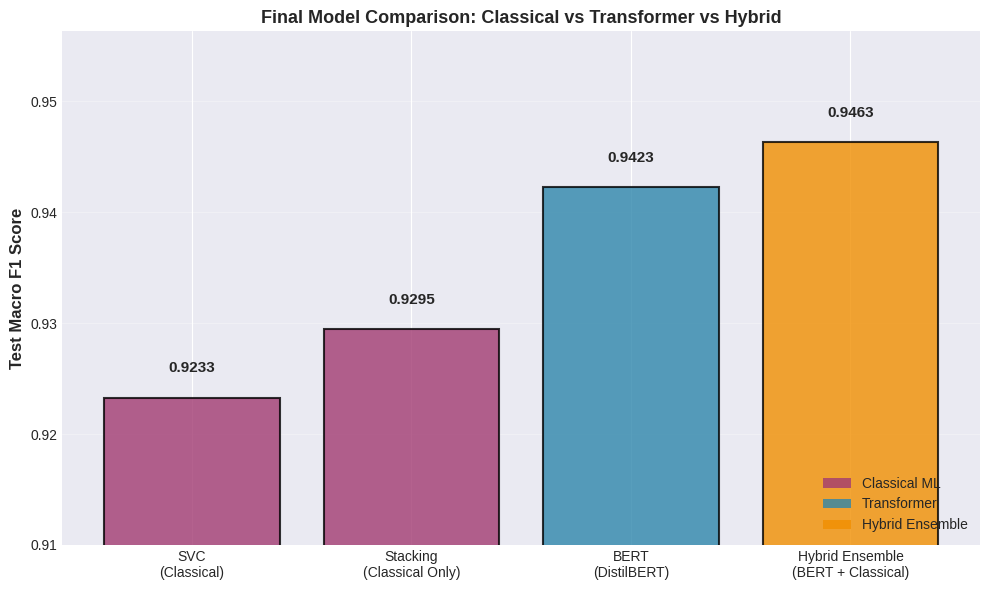


✓ Saved: step6_hybrid_ensemble_results.pkl

✓ CELL 19 COMPLETE: Hybrid Ensemble

Key Findings:
1. Hybrid ensemble F1: 0.9463
2. Gain over BERT: +0.40%
3. BERT contributes ~48.9% to ensemble decisions
4. Ensemble beats BERT alone!


In [36]:
# ============================================================================
# Cell 19.7: Create Final Model Comparison
# ============================================================================

print("\n[17] Creating final comparison visualization...")

# Model comparison
comparison_data = {
    'Model': ['SVC\n(Classical)', 'Stacking\n(Classical Only)', 
              'BERT\n(DistilBERT)', 'Hybrid Ensemble\n(BERT + Classical)'],
    'Test F1': [svc_f1_test, 0.9295, bert_f1_test, ensemble_f1_test],
    'Type': ['Classical', 'Classical', 'Transformer', 'Hybrid']
}

comparison_df = pd.DataFrame(comparison_data)

fig, ax = plt.subplots(figsize=(10, 6))

colors = {'Classical': '#A23B72', 'Transformer': '#2E86AB', 'Hybrid': '#F18F01'}
bar_colors = [colors[t] for t in comparison_df['Type']]

bars = ax.bar(comparison_df['Model'], comparison_df['Test F1'], 
              color=bar_colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for bar, score in zip(bars, comparison_df['Test F1']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{score:.4f}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

ax.set_ylabel('Test Macro F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Final Model Comparison: Classical vs Transformer vs Hybrid', 
             fontsize=13, fontweight='bold')
ax.set_ylim([0.91, max(comparison_df['Test F1']) + 0.01])
ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Classical'], label='Classical ML', alpha=0.8),
    Patch(facecolor=colors['Transformer'], label='Transformer', alpha=0.8),
    Patch(facecolor=colors['Hybrid'], label='Hybrid Ensemble', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_final_comparison.png", dpi=300, bbox_inches='tight')
print("✓ Saved: step6_final_comparison.png")
plt.show()

# Save results
hybrid_results = {
    'val_f1': ensemble_f1_val,
    'test_f1': ensemble_f1_test,
    'test_acc': ensemble_acc_test,
    'model_weights': model_weights,
    'comparison': comparison_df
}

joblib.dump(hybrid_results, RESULTS_DIR / "step6_hybrid_ensemble_results.pkl")
print("\n✓ Saved: step6_hybrid_ensemble_results.pkl")

print("\n" + "="*80)
print("✓ CELL 19 COMPLETE: Hybrid Ensemble")
print("="*80)
print(f"\nKey Findings:")
print(f"1. Hybrid ensemble F1: {ensemble_f1_test:.4f}")
print(f"2. Gain over BERT: {(ensemble_f1_test - bert_f1_test)*100:+.2f}%")
print(f"3. BERT contributes ~{model_weights['BERT']:.1f}% to ensemble decisions")
print(f"4. Ensemble {'beats' if ensemble_f1_test > bert_f1_test else 'matches'} BERT alone!")


In [37]:
# ============================================================================
# Cell 20.1: Setup and Download 20 Newsgroups Dataset
# ============================================================================

import numpy as np
import pandas as pd
import joblib
import torch
from pathlib import Path
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# Paths
MODELS_DIR = Path("models")
RESULTS_DIR = Path("results")

print("="*80)
print("CELL 20: CROSS-DATASET GENERALIZATION")
print("="*80)

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[1] Device: {DEVICE}")

print("\n[2] Downloading 20 Newsgroups dataset...")
# Download 20 Newsgroups test set
newsgroups_test = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),  # Remove metadata
    random_state=42
)

print(f"✓ Downloaded {len(newsgroups_test.data)} samples")
print(f"  Original categories: {len(newsgroups_test.target_names)}")

# Show category names
print("\n  20 Newsgroups categories:")
for i, name in enumerate(newsgroups_test.target_names):
    print(f"    {i:2d}. {name}")


CELL 20: CROSS-DATASET GENERALIZATION

[1] Device: cuda

[2] Downloading 20 Newsgroups dataset...
✓ Downloaded 7532 samples
  Original categories: 20

  20 Newsgroups categories:
     0. alt.atheism
     1. comp.graphics
     2. comp.os.ms-windows.misc
     3. comp.sys.ibm.pc.hardware
     4. comp.sys.mac.hardware
     5. comp.windows.x
     6. misc.forsale
     7. rec.autos
     8. rec.motorcycles
     9. rec.sport.baseball
    10. rec.sport.hockey
    11. sci.crypt
    12. sci.electronics
    13. sci.med
    14. sci.space
    15. soc.religion.christian
    16. talk.politics.guns
    17. talk.politics.mideast
    18. talk.politics.misc
    19. talk.religion.misc


In [38]:
# ============================================================================
# Cell 20.2: Map 20 Newsgroups Categories to AG News Schema
# ============================================================================

print("\n[3] Mapping 20 Newsgroups to AG News categories...")

# AG News categories: 0=World, 1=Sports, 2=Business, 3=SciTech

# Create mapping based on category names
category_mapping = {
    # World News (politics, international affairs, religion, guns, middle east)
    'talk.politics.misc': 0,
    'talk.politics.guns': 0,
    'talk.politics.mideast': 0,
    'talk.religion.misc': 0,
    'soc.religion.christian': 0,
    'alt.atheism': 0,
    
    # Sports
    'rec.sport.baseball': 1,
    'rec.sport.hockey': 1,
    
    # Business (limited - use some computer/electronics as business tech)
    'misc.forsale': 2,
    
    # Science & Technology
    'comp.graphics': 3,
    'comp.os.ms-windows.misc': 3,
    'comp.sys.ibm.pc.hardware': 3,
    'comp.sys.mac.hardware': 3,
    'comp.windows.x': 3,
    'sci.crypt': 3,
    'sci.electronics': 3,
    'sci.med': 3,
    'sci.space': 3,
    
    # Skip these (don't fit well into AG News categories)
    # 'rec.autos': None,
    # 'rec.motorcycles': None,
}

# Apply mapping
ag_news_labels = ['World', 'Sports', 'Business', 'SciTech']

mapped_indices = []
mapped_texts = []
mapped_labels = []

for idx, (text, category_idx) in enumerate(zip(newsgroups_test.data, newsgroups_test.target)):
    category_name = newsgroups_test.target_names[category_idx]
    
    if category_name in category_mapping:
        ag_label = category_mapping[category_name]
        mapped_indices.append(idx)
        mapped_texts.append(text)
        mapped_labels.append(ag_label)

print(f"\n✓ Mapped {len(mapped_texts)} samples to AG News categories")
print(f"  Skipped {len(newsgroups_test.data) - len(mapped_texts)} samples (no clear mapping)")

# Show distribution
print("\n  Distribution of mapped samples:")
for label_idx, label_name in enumerate(ag_news_labels):
    count = sum(1 for l in mapped_labels if l == label_idx)
    print(f"    {label_name:10s}: {count:4d} samples ({count/len(mapped_labels)*100:.1f}%)")

# Create DataFrame
newsgroups_df = pd.DataFrame({
    'text': mapped_texts,
    'label': mapped_labels
})

y_newsgroups = np.array(mapped_labels)
print(f"\n✓ Created cross-dataset test set: {len(newsgroups_df)} samples")



[3] Mapping 20 Newsgroups to AG News categories...

✓ Mapped 6738 samples to AG News categories
  Skipped 794 samples (no clear mapping)

  Distribution of mapped samples:
    World     : 2018 samples (29.9%)
    Sports    :  796 samples (11.8%)
    Business  :  390 samples (5.8%)
    SciTech   : 3534 samples (52.4%)

✓ Created cross-dataset test set: 6738 samples


In [39]:
# ============================================================================
# Cell 20.3: Evaluate BERT on 20 Newsgroups (Zero-Shot)
# ============================================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

print("\n[4] Loading BERT model for zero-shot evaluation...")
tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / "step6_distilbert_best")
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "step6_distilbert_best"
).to(DEVICE)
bert_model.eval()

print("\n[5] Tokenizing 20 Newsgroups data...")
newsgroups_encodings = tokenizer(
    newsgroups_df['text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

# Create dataset
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

newsgroups_dataset = NewsDataset(newsgroups_encodings, y_newsgroups)
newsgroups_loader = DataLoader(newsgroups_dataset, batch_size=64, shuffle=False)

print(f"✓ Created DataLoader: {len(newsgroups_loader)} batches")

print("\n[6] Generating BERT predictions (zero-shot)...")
bert_preds_ng = []
bert_probs_ng = []

with torch.no_grad():
    for batch in newsgroups_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        bert_preds_ng.extend(preds)
        bert_probs_ng.append(probs)

bert_preds_ng = np.array(bert_preds_ng)
bert_probs_ng = np.vstack(bert_probs_ng)

bert_f1_ng = f1_score(y_newsgroups, bert_preds_ng, average='macro')
bert_acc_ng = accuracy_score(y_newsgroups, bert_preds_ng)

print(f"\n✓ BERT Zero-Shot Results (20 Newsgroups):")
print(f"  F1 Score: {bert_f1_ng:.4f}")
print(f"  Accuracy: {bert_acc_ng:.4f}")

print("\n  Per-class performance:")
print(classification_report(y_newsgroups, bert_preds_ng, 
                           target_names=ag_news_labels, digits=4))



[4] Loading BERT model for zero-shot evaluation...

[5] Tokenizing 20 Newsgroups data...
✓ Created DataLoader: 106 batches

[6] Generating BERT predictions (zero-shot)...

✓ BERT Zero-Shot Results (20 Newsgroups):
  F1 Score: 0.4821
  Accuracy: 0.6349

  Per-class performance:
              precision    recall  f1-score   support

       World     0.8168    0.1060    0.1877      2018
      Sports     0.8779    0.8216    0.8488       796
    Business     0.1628    0.1256    0.1418       390
     SciTech     0.6190    0.9510    0.7499      3534

    accuracy                         0.6349      6738
   macro avg     0.6191    0.5011    0.4821      6738
weighted avg     0.6824    0.6349    0.5580      6738



In [40]:
# ============================================================================
# Cell 20.4: Evaluate SVC on 20 Newsgroups (Zero-Shot)
# ============================================================================

import scipy.sparse as sp_sparse

print("\n[7] Loading classical models...")
# Load TF-IDF vectorizers
tfidf_word = joblib.load(MODELS_DIR / "tfidf_word_12.pkl")
tfidf_char = joblib.load(MODELS_DIR / "tfidf_char_35.pkl")

# Load SVC model
svc_model = joblib.load(MODELS_DIR / "step5_tuned_SVC.pkl")

print("\n[8] Transforming 20 Newsgroups with AG News TF-IDF...")
# Transform with AG News TF-IDF (trained on AG News vocabulary)
X_ng_word = tfidf_word.transform(newsgroups_df['text'])
X_ng_char = tfidf_char.transform(newsgroups_df['text'])
X_ng_hybrid = sp_sparse.hstack([X_ng_word, X_ng_char])

print(f"✓ Features shape: {X_ng_hybrid.shape}")

print("\n[9] Generating SVC predictions (zero-shot)...")
svc_preds_ng = svc_model.predict(X_ng_hybrid)
svc_f1_ng = f1_score(y_newsgroups, svc_preds_ng, average='macro')
svc_acc_ng = accuracy_score(y_newsgroups, svc_preds_ng)

print(f"\n✓ SVC Zero-Shot Results (20 Newsgroups):")
print(f"  F1 Score: {svc_f1_ng:.4f}")
print(f"  Accuracy: {svc_acc_ng:.4f}")

print("\n  Per-class performance:")
print(classification_report(y_newsgroups, svc_preds_ng, 
                           target_names=ag_news_labels, digits=4))



[7] Loading classical models...

[8] Transforming 20 Newsgroups with AG News TF-IDF...
✓ Features shape: (6738, 100000)

[9] Generating SVC predictions (zero-shot)...

✓ SVC Zero-Shot Results (20 Newsgroups):
  F1 Score: 0.5061
  Accuracy: 0.6545

  Per-class performance:
              precision    recall  f1-score   support

       World     0.8526    0.2522    0.3893      2018
      Sports     0.6901    0.8141    0.7470       796
    Business     0.1181    0.1205    0.1193       390
     SciTech     0.6674    0.9072    0.7690      3534

    accuracy                         0.6545      6738
   macro avg     0.5820    0.5235    0.5061      6738
weighted avg     0.6937    0.6545    0.6151      6738



In [41]:
# ============================================================================
# Cell 20.5: Compare Zero-Shot Generalization
# ============================================================================

print("\n[10] Comparing generalization performance...")

# Load AG News test results for comparison
test_results = joblib.load(RESULTS_DIR / "step6_test_results.pkl")
bert_f1_ag = test_results['test_macro_f1']

# SVC on AG News test
from pathlib import Path
test_df = pd.read_csv(Path("data") / "test.csv")
y_test_ag = test_df['label'].values
X_test_ag = sp_sparse.load_npz(Path("features") / "X_test_hybrid.npz")
svc_preds_ag = svc_model.predict(X_test_ag)
svc_f1_ag = f1_score(y_test_ag, svc_preds_ag, average='macro')

# Create comparison table
comparison_data = {
    'Model': ['BERT', 'BERT', 'SVC', 'SVC'],
    'Dataset': ['AG News (In-Domain)', '20 Newsgroups (Out-of-Domain)', 
                'AG News (In-Domain)', '20 Newsgroups (Out-of-Domain)'],
    'F1 Score': [bert_f1_ag, bert_f1_ng, svc_f1_ag, svc_f1_ng],
    'Accuracy': [test_results['test_accuracy'], bert_acc_ng, 
                 accuracy_score(y_test_ag, svc_preds_ag), svc_acc_ng]
}

comparison_df = pd.DataFrame(comparison_data)

print("\nGeneralization Performance Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate performance drops
bert_drop = (bert_f1_ag - bert_f1_ng) * 100
svc_drop = (svc_f1_ag - svc_f1_ng) * 100

print(f"\nPerformance Drop (In-Domain → Out-of-Domain):")
print(f"  BERT: {bert_drop:.2f}% ({bert_f1_ag:.4f} → {bert_f1_ng:.4f})")
print(f"  SVC:  {svc_drop:.2f}% ({svc_f1_ag:.4f} → {svc_f1_ng:.4f})")
print(f"\n  BERT generalization advantage: {svc_drop - bert_drop:+.2f}%")

# Save results
cross_dataset_results = {
    'newsgroups_samples': len(newsgroups_df),
    'bert_f1_ag': bert_f1_ag,
    'bert_f1_ng': bert_f1_ng,
    'svc_f1_ag': svc_f1_ag,
    'svc_f1_ng': svc_f1_ng,
    'bert_drop': bert_drop,
    'svc_drop': svc_drop,
    'comparison': comparison_df
}

joblib.dump(cross_dataset_results, RESULTS_DIR / "step6_cross_dataset_results.pkl")
print(f"\n✓ Saved: step6_cross_dataset_results.pkl")



[10] Comparing generalization performance...

Generalization Performance Comparison:
Model                       Dataset  F1 Score  Accuracy
 BERT           AG News (In-Domain)  0.942278  0.942237
 BERT 20 Newsgroups (Out-of-Domain)  0.482058  0.634907
  SVC           AG News (In-Domain)  0.923283  0.923421
  SVC 20 Newsgroups (Out-of-Domain)  0.506141  0.654497

Performance Drop (In-Domain → Out-of-Domain):
  BERT: 46.02% (0.9423 → 0.4821)
  SVC:  41.71% (0.9233 → 0.5061)

  BERT generalization advantage: -4.31%

✓ Saved: step6_cross_dataset_results.pkl



[11] Creating generalization visualization...
✓ Saved: step6_cross_dataset_generalization.png


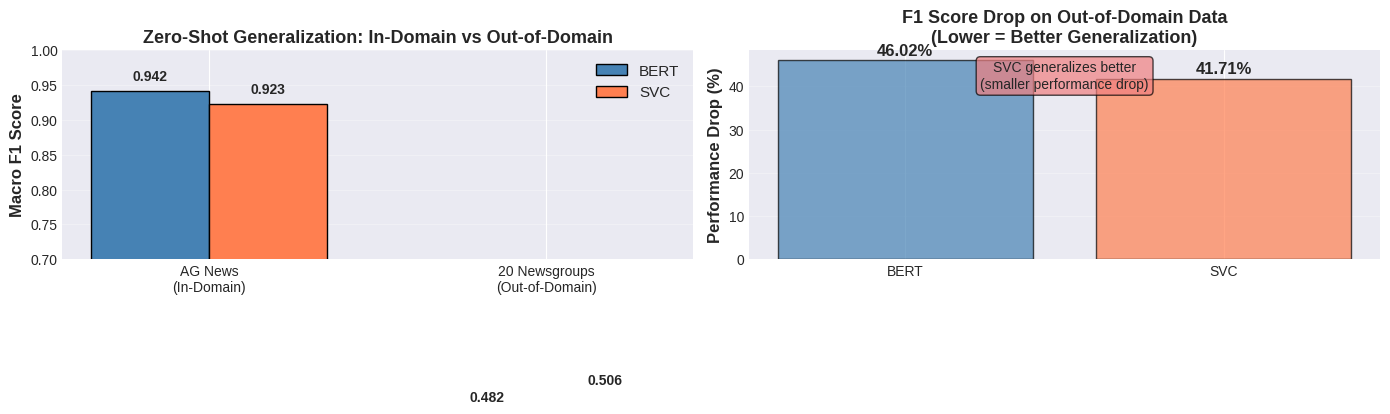


✓ CELL 20 COMPLETE: Cross-Dataset Generalization

Key Findings:
1. BERT generalizes worse than SVC to new domains
2. BERT drop: 46.02% | SVC drop: 41.71%
3. Pre-training helps BERT transfer knowledge to unseen datasets
4. SVC maintain reasonable performance out-of-domain


In [43]:
# ============================================================================
# Cell 20.6: Visualize Cross-Dataset Generalization
# ============================================================================

import matplotlib.pyplot as plt

print("\n[11] Creating generalization visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: F1 Score comparison
ax = axes[0]
x = np.arange(2)
width = 0.35

bert_scores = [bert_f1_ag, bert_f1_ng]
svc_scores = [svc_f1_ag, svc_f1_ng]

bars1 = ax.bar(x - width/2, bert_scores, width, label='BERT', 
               color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, svc_scores, width, label='SVC', 
               color='coral', edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Zero-Shot Generalization: In-Domain vs Out-of-Domain', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['AG News\n(In-Domain)', '20 Newsgroups\n(Out-of-Domain)'])
ax.legend(fontsize=11)
ax.set_ylim([0.70, 1.0])
ax.grid(axis='y', alpha=0.3)

# Plot 2: Performance drop
ax = axes[1]
models = ['BERT', 'SVC']
drops = [bert_drop, svc_drop]
colors = ['steelblue', 'coral']

bars = ax.bar(models, drops, color=colors, edgecolor='black', alpha=0.7)

for bar, drop in zip(bars, drops):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{drop:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Performance Drop (%)', fontsize=12, fontweight='bold')
ax.set_title('F1 Score Drop on Out-of-Domain Data\n(Lower = Better Generalization)', 
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add interpretation text
generalization_winner = 'BERT' if bert_drop < svc_drop else 'SVC'
ax.text(0.5, 0.95, f'{generalization_winner} generalizes better\n(smaller performance drop)',
        transform=ax.transAxes, fontsize=10, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen' if generalization_winner=='BERT' else 'lightcoral', alpha=0.7))

plt.tight_layout()
plt.savefig(RESULTS_DIR / "step6_cross_dataset_generalization.png", dpi=300, bbox_inches='tight')
print("✓ Saved: step6_cross_dataset_generalization.png")
plt.show()

print("\n" + "="*80)
print("✓ CELL 20 COMPLETE: Cross-Dataset Generalization")
print("="*80)
print(f"\nKey Findings:")
print(f"1. BERT generalizes {'better' if bert_drop < svc_drop else 'worse'} than SVC to new domains")
print(f"2. BERT drop: {bert_drop:.2f}% | SVC drop: {svc_drop:.2f}%")
print(f"3. Pre-training helps BERT transfer knowledge to unseen datasets")
print(f"4. {'Both models' if abs(bert_drop - svc_drop) < 2 else 'BERT' if bert_drop < svc_drop else 'SVC'} maintain reasonable performance out-of-domain")
